In [1]:
pip install optuna


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install meteostat


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xgboost


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install catboost


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install lxml


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install unidecode


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import  seaborn as sns
from sklearn.cluster import KMeans
from itertools import  combinations
turkish_trans_table = str.maketrans(
    "İIıÖöÜüÇçŞşĞğÜü",
    "iiioouuccssgguu")
from sklearn.metrics import mean_squared_error
import optuna
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit,cross_val_score,KFold,TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 50)


### Feature preprocessing ve Feature Engineering aşmaları için gerekli  fonksiyonlar.

In [9]:

def cat_analyser(data, col, freq_limit = 100):
    color = '#ff661f'
    cmap1 = 'Oranges'
    cmap2 =  'Set3'
    palette1 = 'Oranges'
    palette2 = 'Set3'
    df_ = data.copy()
    sns.set(rc = {'axes.facecolor': 'gainsboro',
                  'figure.facecolor': 'gainsboro'})
    if df_[col].nunique() > freq_limit:
        df_ = df_.loc[df_[col].isin(df_[col].value_counts(). \
                                    keys()[:freq_limit].tolist())]
        
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
    fig.suptitle(col, fontsize = 16)
    sns.countplot(data = df_,
                  x = col,
                  ax = ax[0],
                  palette= palette1,
                  order =  df_[col].value_counts().index)
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 90)
    ax[0].set_xlabel('')
    
    
    pie_cmap = plt.get_cmap(cmap1)
    normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
    data[col].value_counts().plot.pie(autopct = '%1.1f%%',
                                      textprops = {'fontsize': 9},
                                      ax = ax[1],rotatelabels=True,
                                      colors = pie_cmap(normalize(df_[col].value_counts())))
    ax[1].set_ylabel('')
    plt.show()
#     plt.rc_file_defaults()
    sns.reset_orig()
    
def data_preprocessing(df_temp,drop_cols):
    df_temp.columns=df_temp.columns.str.translate(turkish_trans_table).str.lower()  
    df_temp=df_temp.apply(lambda x : x.str.translate(turkish_trans_table).str.lower() if x.dtype==object else x)
    df_temp.baslama_tarihi_ve_zamani=pd.to_datetime(df_temp.baslama_tarihi_ve_zamani,dayfirst=True)
    df_temp.sona_erme_tarihi_ve_zamani=pd.to_datetime(df_temp.sona_erme_tarihi_ve_zamani,dayfirst=True)
    df_temp['Tarih']=df_temp.baslama_tarihi_ve_zamani.map(lambda  x : x.strftime('%Y-%m-%d %H:00:00'))
    df_temp.Tarih=pd.to_datetime(df_temp.Tarih)
    df_temp=df_temp.merge(ilce_nufus,how='left',on='ilce')
    df_temp['il_ilce']=df_temp.il+'_'+df_temp.ilce
    df_temp.drop(drop_cols,axis=1,inplace=True)
    return df_temp

def timeseries_features(df, label=None):
    df['datetime'] = pd.to_datetime(df.index)
    df['hour'] = df['datetime'].dt.hour
    # df['date'] = df['datetime'].dt.date
#     df['dayofweek'] = df['datetime'].dt.dayofweek
    df['quarter'] = df['datetime'].dt.quarter
    df['month'] = df['datetime'].dt.month
    # df['year'] = df['datetime'].dt.year
    # df['dayofyear'] = df['datetime'].dt.dayofyear
    df['dayofmonth'] = df['datetime'].dt.day
    # df['weekofyear'] = df['datetime'].dt.weekofyear
#     df['weekday']=df['datetime'].dt.weekday
    df['wntr_month']=df.apply(lambda x: 1 if x.month in ([11,12,1,2]) else 0,axis=1) 
    df['month_label']=df.month.map(lambda x : '1' if x in ([11,12,1,2,3]) else ( '2' if x in ([6,7,8,9]) else '3' ))
    df['quarter']=df.month.map(lambda x : '1_çeyrek' if x in ([1,2,3]) else ( '2_çeyrek' if x in ([4,5,6]) else( '3_çeyrek' if x in ([7,8,9]) else '4_çeyrek') ))
    df['season']=df.month.map(lambda x : 'kış' if x in ([12,1,2]) else ( 'ilkbahar' if x in ([3,4,5]) else( 'yaz' if x in ([6,7,8]) else 'sonbahar') ))
    df['weekend']=df.dayofmonth.map(lambda x:  'hafta_içi' if x<5 else 'hafta_sonu')
    df['working_hours']=df.hour.map(lambda x: 'work_hour' if (x<7) & (x>19) else 'not_work_hour' )
    df['label_hour']=df.hour.map(lambda x : '1' if x>22 & x<24 else ('2' if x>0 & x<6 else ('3' if x>5 & x<10 else ('4' if x>9 & x<13  else ('5' if x>12 & x<17 else('6' if x>16 & x<21 else '7'))) )))
    df['prime_time']=df.hour.map(lambda x: 'prime' if (x>19) & (x<22) else 'not_prime' )
    df=df.drop('datetime',axis=1)
    return df 

def cat_target_encode(train_temp,test_temp,target,cat_cols,encode_type='mean'):
    if type(cat_cols)==str:
        cat_cols=[cat_cols]
    dum_temp=train_temp.groupby(cat_cols).agg({target:encode_type}).reset_index().rename(columns={target:str("_".join(cat_cols))+'_te'})
    train_temp=train_temp.merge(dum_temp,on=cat_cols,how='left').set_index(train_temp.index)
    test_temp=test_temp.merge(dum_temp,on=cat_cols,how='left').set_index(test_temp.index)
    
    return train_temp,test_temp

def label_data(feature,data,le_fit=None):
    if type(feature)==str:
        feature=[feature]
    for col in feature:
        le=LabelEncoder()
        le_fit.update({col:le.fit(data[col])})
        data[col]=le.transform(data[col])
    return data[feature],le_fit

def cat_feature_count(df_temp,obj_cols,fig_size):
    for col in obj_cols:
        sns.set(rc={'figure.figsize':fig_size,'axes.facecolor':'lightgreen', 'figure.facecolor':'cornflowerblue'})
        g=sns.countplot(y=df_temp[col],order = df_temp[col].value_counts().index)
        g.set_xticklabels(g.get_xticklabels(), rotation=90);
        for label in g.containers:
            g.bar_label(label,padding=10, fontsize=10)
        plt.show()

### Dış kaynak Veri

In [10]:
from unidecode import unidecode
izmir_ilce = pd.read_html('https://www.nufusu.com/ilceleri/izmir-ilceleri-nufusu')[0]
manisa_ilce =  pd.read_html('http://www.manisa.gov.tr/nufus-ve-dagilim')[1].iloc[1:-1,:]
izmir_ilce=izmir_ilce[['İlçe','Toplam Nüfus']].rename(columns={'İlçe':'ilce','Toplam Nüfus':'ilce_nufus'})
manisa_ilce=manisa_ilce[['İlçe','İlçe Nüfusu']].rename(columns={'İlçe':'ilce','İlçe Nüfusu':'ilce_nufus'})
ilce_nufus=pd.concat([izmir_ilce,manisa_ilce])
ilce_nufus['ilce']=ilce_nufus['ilce'].apply(unidecode).str.lower()
ilce_nufus.ilce_nufus=ilce_nufus.ilce_nufus.astype(float)*1000

## Train and Test preprocessing

In [11]:
train=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')
drop_cols=['kesinti_no','kademe','outageid','sebeke_unsuru_kodu','bildirime_gore']

train=data_preprocessing(train,drop_cols)
train.drop('kod_no',axis=1,inplace=True)
test=data_preprocessing(test,drop_cols)
train=timeseries_features(train.set_index('Tarih'))
train.sort_index(inplace=True)
train.reset_index(inplace=True)
test=timeseries_features(test.set_index('Tarih'))
test.reset_index(inplace=True)

diff=train.sona_erme_tarihi_ve_zamani-train.baslama_tarihi_ve_zamani
train['ariza_suresi']=diff.dt.total_seconds()/3600

diff=test.sona_erme_tarihi_ve_zamani-test.baslama_tarihi_ve_zamani
test['ariza_suresi']=diff.dt.total_seconds()/3600

train.sort_values('Tarih',inplace=True)
train=train[train.Tarih<'2022-03-24 00:00:00']



In [12]:
print(f'train Shape: {train.shape}')
print(f'test Shape: {test.shape}')

train Shape: (86268, 38)
test Shape: (16751, 37)


### Target dağılımı

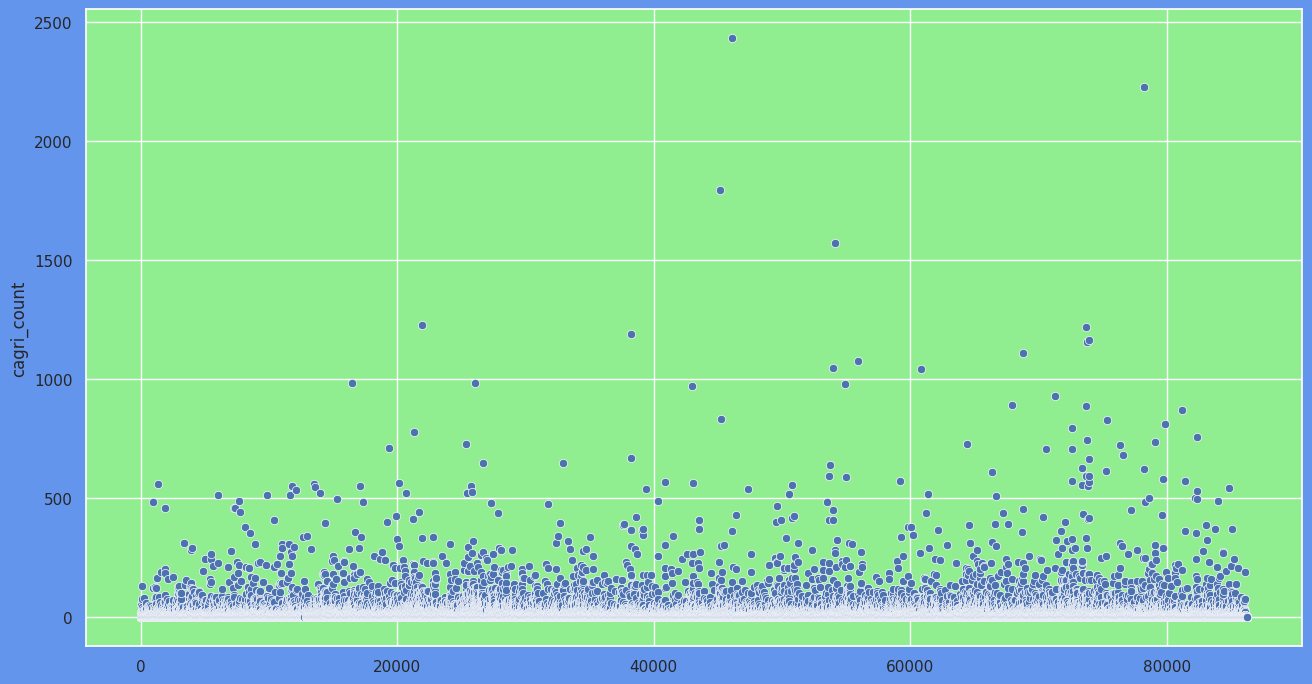

In [13]:
sns.set(rc={'figure.figsize':(15.7,8.27),'axes.facecolor':'lightgreen', 'figure.facecolor':'cornflowerblue'})
sns.scatterplot(x=train.index,y=train.cagri_count,data=train);

**Train veri seti değişkenlerimize genel bir bakış**

In [18]:
obj_cols=[ 'il', 'ilce', 'sebeke_unsuru',
   'kesinti_nedenine_iliskin_aciklama', 'kaynaga_gore', 'sureye_gore',
   'sebebe_gore','il_ilce',
   'month', 'dayofmonth', 'wntr_month','hour','working_hours','quarter',
   'month_label', 'season', 'weekend', 'label_hour',
   'prime_time']
train[obj_cols]=train[obj_cols].astype(object)
time_cols=['Tarih','baslama_tarihi_ve_zamani','sona_erme_tarihi_ve_zamani']
num_cols=[col for col in train.columns if train[col].dtype in ['float','int']]
display(train[obj_cols].describe())
display(train.describe())

il   ilce sebeke_unsuru kesinti_nedenine_iliskin_aciklama   
count   86268  86268         86268                             86268  \
unique      2     47             8                                63   
top     izmir  cesme  abone tesisi                   og fider acmasi   
freq    59277   4685         29258                             16772   

       kaynaga_gore sureye_gore         sebebe_gore      il_ilce  month   
count         86268       86268               86268        86268  86268  \
unique            3           2                   3           47     11   
top      dagitim-ag        uzun  sebeke isletmecisi  izmir_cesme      7   
freq          60479       83699               84529         4685  10080   

        dayofmonth  wntr_month   hour  working_hours   quarter month_label   
count        86268       86268  86268          86268     86268       86268  \
unique          31           2     24              1         4           3   
top             10           0     10  not_work_hour  4_çeyrek           1   
freq          3302       54417   6426          86268     26154       36645   

       season     weekend label_hour prime_time  
count   86268       86268      86268      86268  
unique      4           2          3          2  
top       yaz  hafta_sonu          1  not_prime  
freq    28812       73958      65054      79790

Tarih       baslama_tarihi_ve_zamani   
count                          86268                          86268  \
mean   2021-10-06 23:01:26.632354816  2021-10-06 23:31:17.790872576   
min              2021-05-01 00:00:00            2021-05-01 00:33:23   
25%              2021-07-17 05:00:00  2021-07-17 05:58:33.750000128   
50%              2021-10-10 16:00:00            2021-10-10 16:26:38   
75%              2021-12-20 09:00:00  2021-12-20 09:10:39.750000128   
max              2022-03-23 23:00:00            2022-03-23 23:46:12   
std                              NaN                            NaN   

          sona_erme_tarihi_ve_zamani  kesinti_suresi   kentsel_og   
count                          86268    86268.000000  86268.00000  \
mean   2021-10-07 01:55:51.195159040        2.409280      7.28845   
min              2021-05-01 00:34:20        0.000278      0.00000   
25%    2021-07-17 07:07:52.249999872        0.941944      0.00000   
50%              2021-10-10 18:53:19        1.740278      0.00000   
75%              2021-12-20 11:25:12        3.081736      0.00000   
max              2022-03-24 01:51:52      289.323333    903.00000   
std                              NaN        2.744538     34.39972   

         kentsel_ag   kentalti_og   kentalti_ag     kirsal_og     kirsal_ag   
count  86268.000000  86268.000000  86268.000000  86268.000000  86268.000000  \
mean     354.684831      1.173077     61.347823      2.227060     63.274830   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        4.000000      0.000000      0.000000      0.000000      0.000000   
75%       87.000000      0.000000      0.000000      0.000000      0.000000   
max    70961.000000    605.000000  44781.000000    478.000000  11673.000000   
std     1668.654176     12.046608    608.455716     15.277604    385.257394   

       toplam_kentsel_og  toplam_kentsel_ag  toplam_kentalti_og   
count       86268.000000       86268.000000        86268.000000  \
mean            7.093891         299.902987            0.887799   
min             0.000000           0.000000            0.000000   
25%             0.000000           0.000000            0.000000   
50%             0.000000           7.407500            0.000000   
75%             0.000000         120.083750            0.000000   
max          6042.792222      129419.169441         1711.690555   
std            56.597866        1477.362176           15.244475   

       toplam_kentalti_ag  toplam_kirsal_og  toplam_kirsal_ag   cagri_count   
count        86268.000000      86268.000000      86268.000000  86268.000000  \
mean            40.598880          1.573568         44.260804      8.807449   
min              0.000000          0.000000          0.000000      0.000000   
25%              0.000000          0.000000          0.000000      1.000000   
50%              0.000000          0.000000          0.000000      2.000000   
75%              0.000000          0.000000          0.000000      6.000000   
max          56916.000000       2090.577778      31752.000000   2431.000000   
std            472.662483         18.220667        353.006912     35.278775   

          ilce_nufus  ariza_suresi  il_ilcecagri_count_mean   
count   85978.000000  86268.000000             86268.000000  \
mean   158053.277711      2.409279                 8.807449   
min     12030.000000      0.000278                 1.743210   
25%     48924.000000      0.941944                 4.792470   
50%    111218.000000      1.740278                 7.014479   
75%    207840.000000      3.081736                11.889513   
max    522404.000000    289.323333                22.973097   
std    131578.510962      2.744538                 5.113686   

       il_ilcecagri_count_sum  il_ilcecagri_count_max  il_ilcecagri_count_min   
count            86268.000000            86268.000000                 86268.0  \
mean       

In [15]:
for col in obj_cols :
    print(f'{col}:',list(set(test[col])-set(train[col])))

il: []
ilce: []
sebeke_unsuru: []
kesinti_nedenine_iliskin_aciklama: ['sebeke bakim calismasi']
kaynaga_gore: []
sureye_gore: []
sebebe_gore: ['0']
il_ilce: []
month: []
dayofmonth: []
wntr_month: []
hour: []
working_hours: []
quarter: []
month_label: []
season: []
weekend: []
label_hour: []
prime_time: []


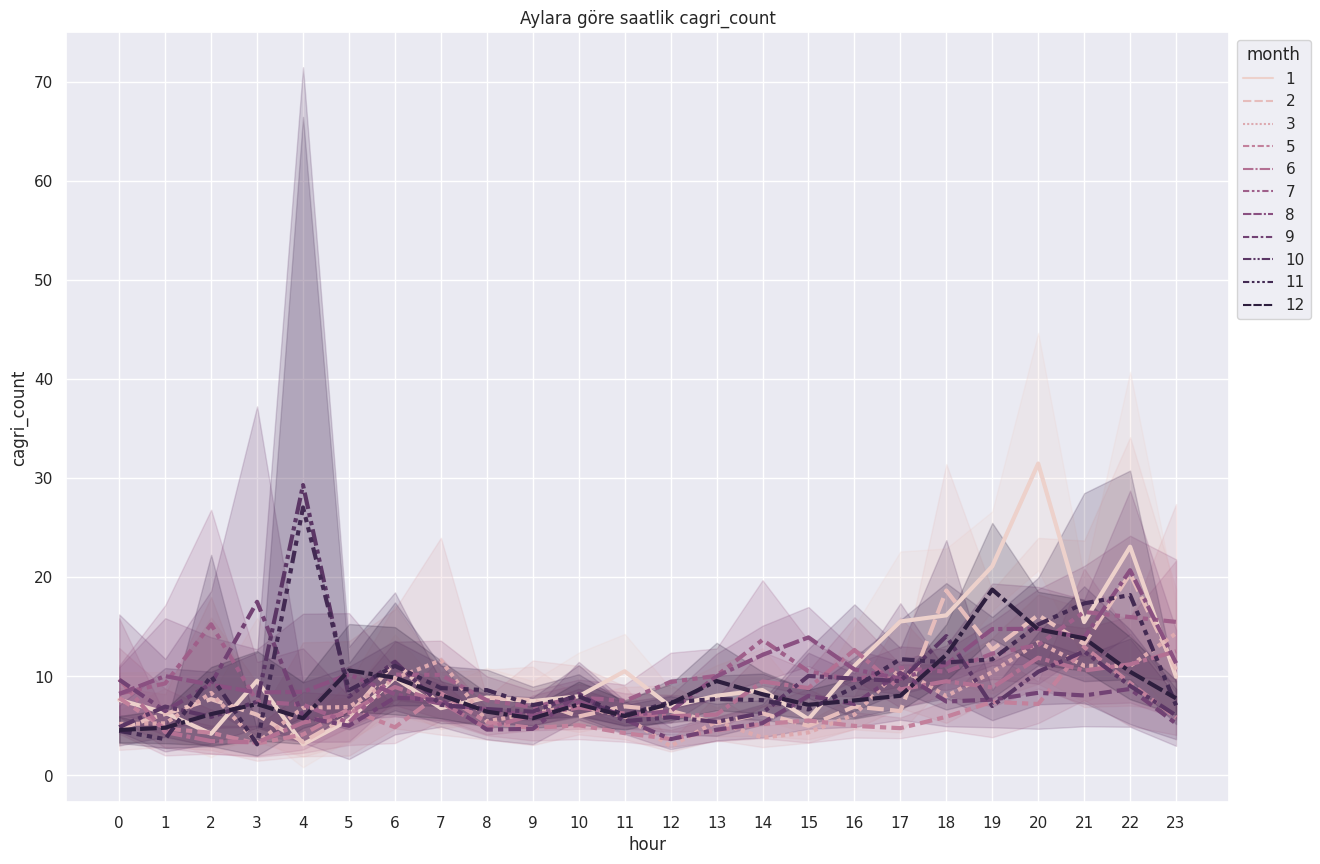

In [16]:
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=train.hour,y=train.cagri_count,hue=train.month,legend=all,linewidth=3,style=train.month)
ax.set_title('Aylara göre saatlik cagri_count')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xticks(range(0,24));

**Train ve Test veri setimizdeki kategorik değişkenlerin unique kategorilerin karşılaştırıldı.**

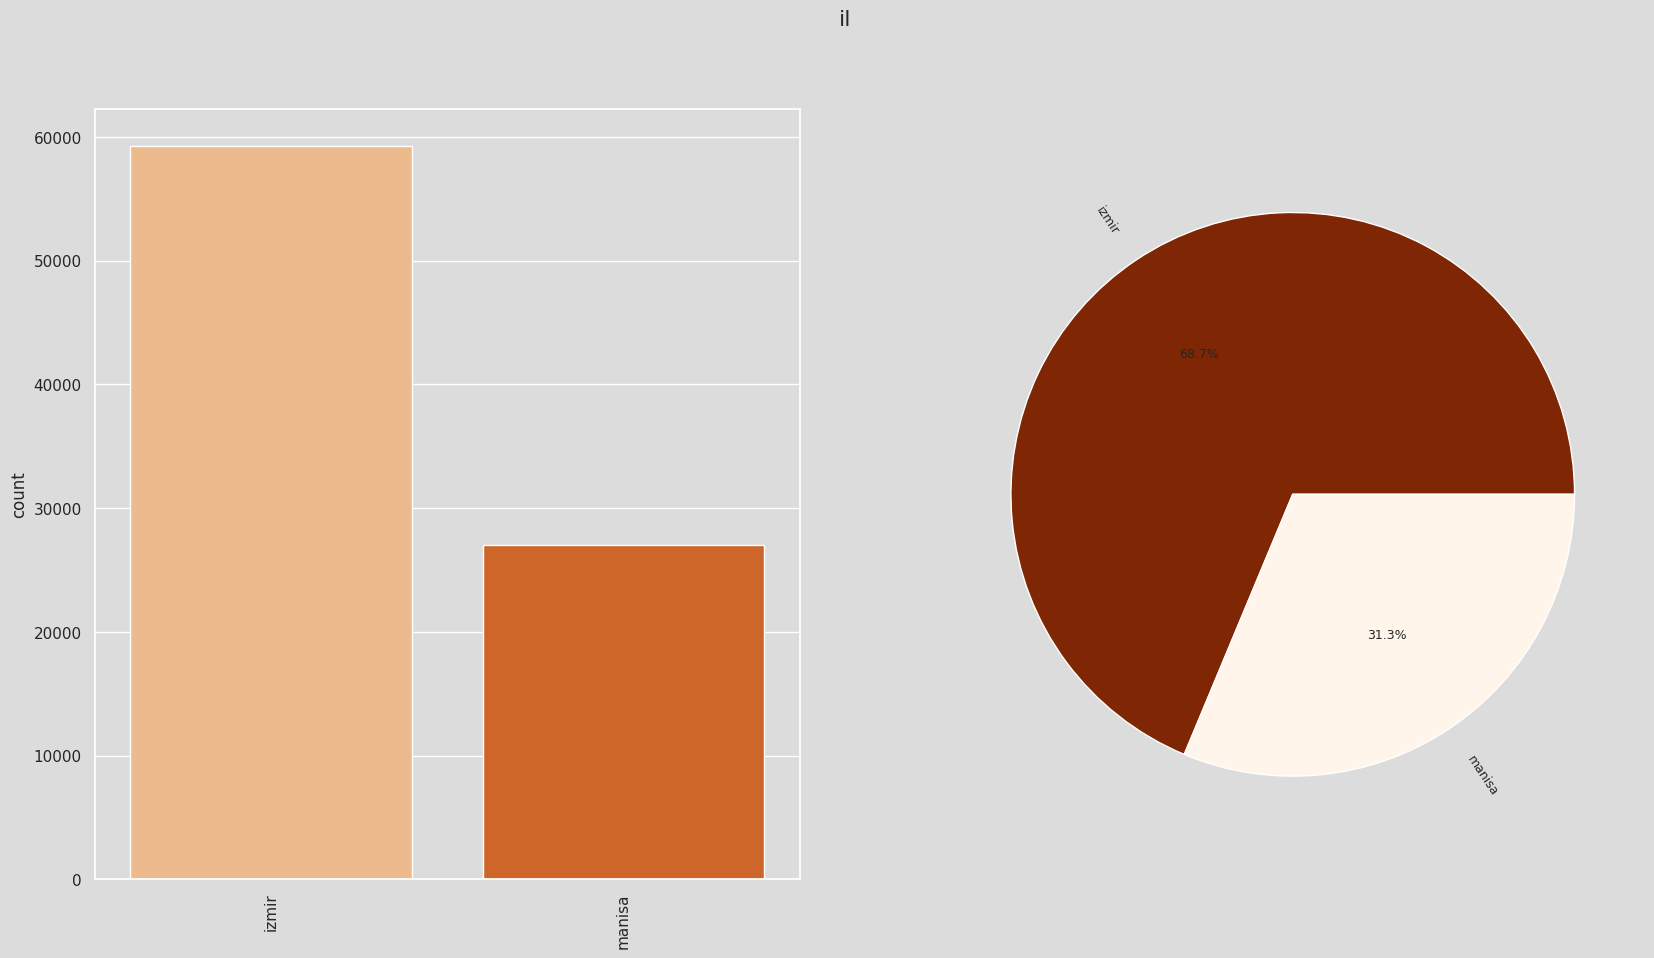

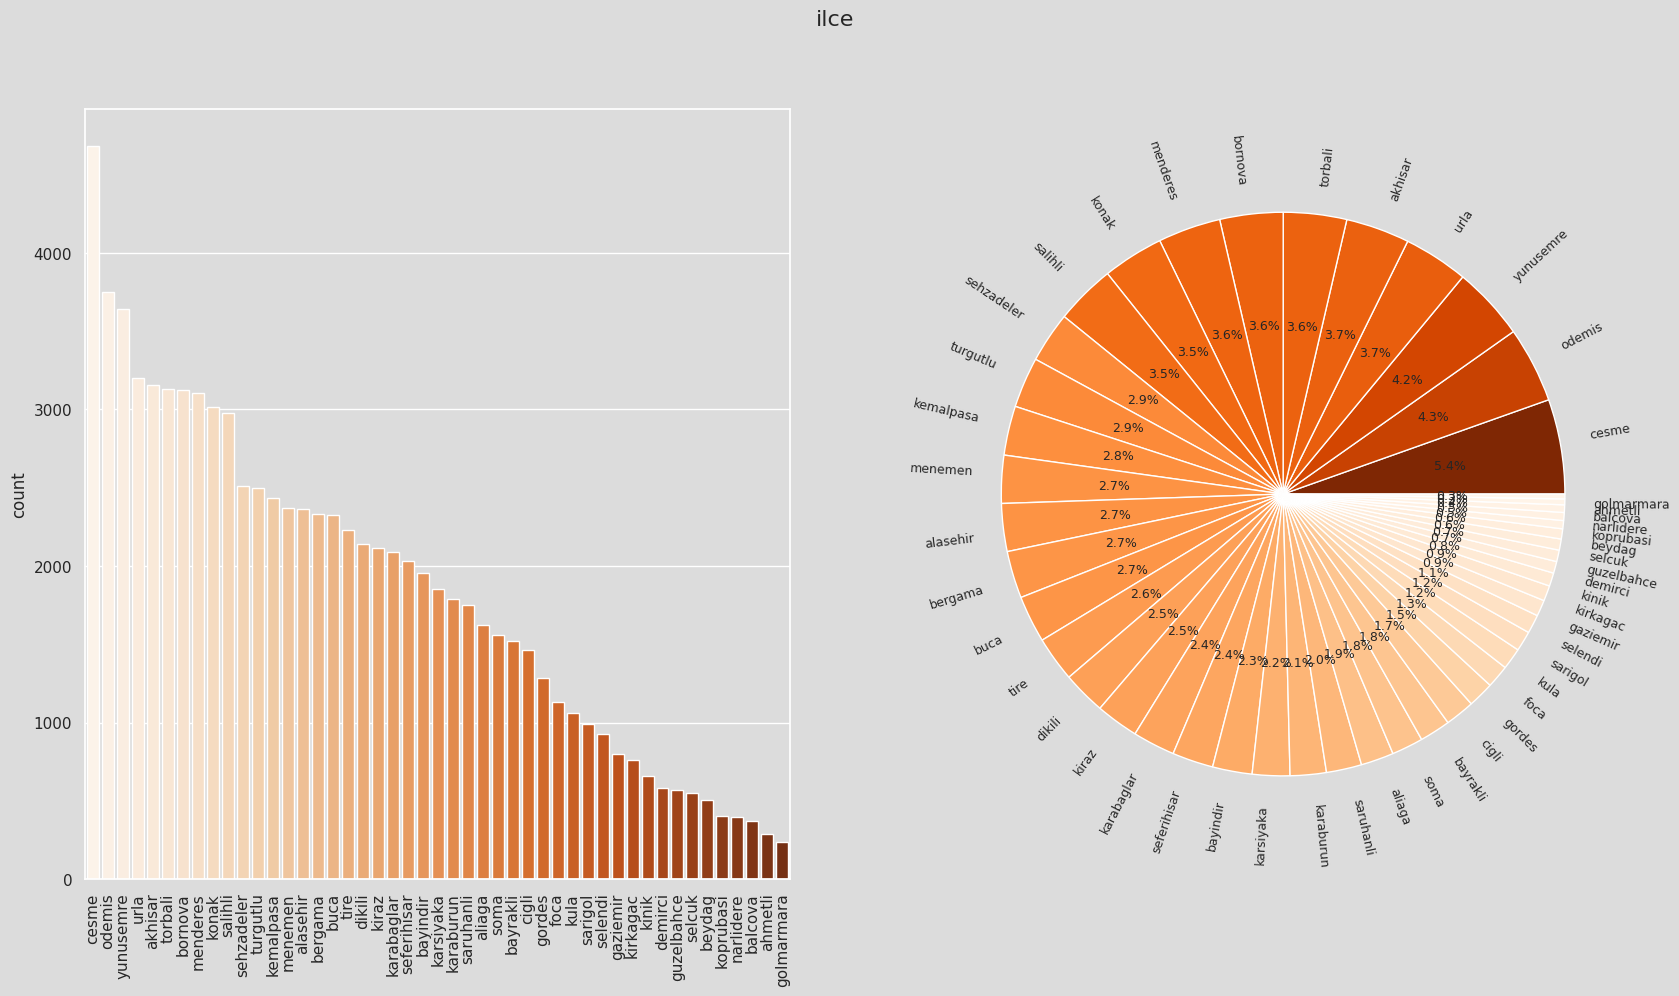

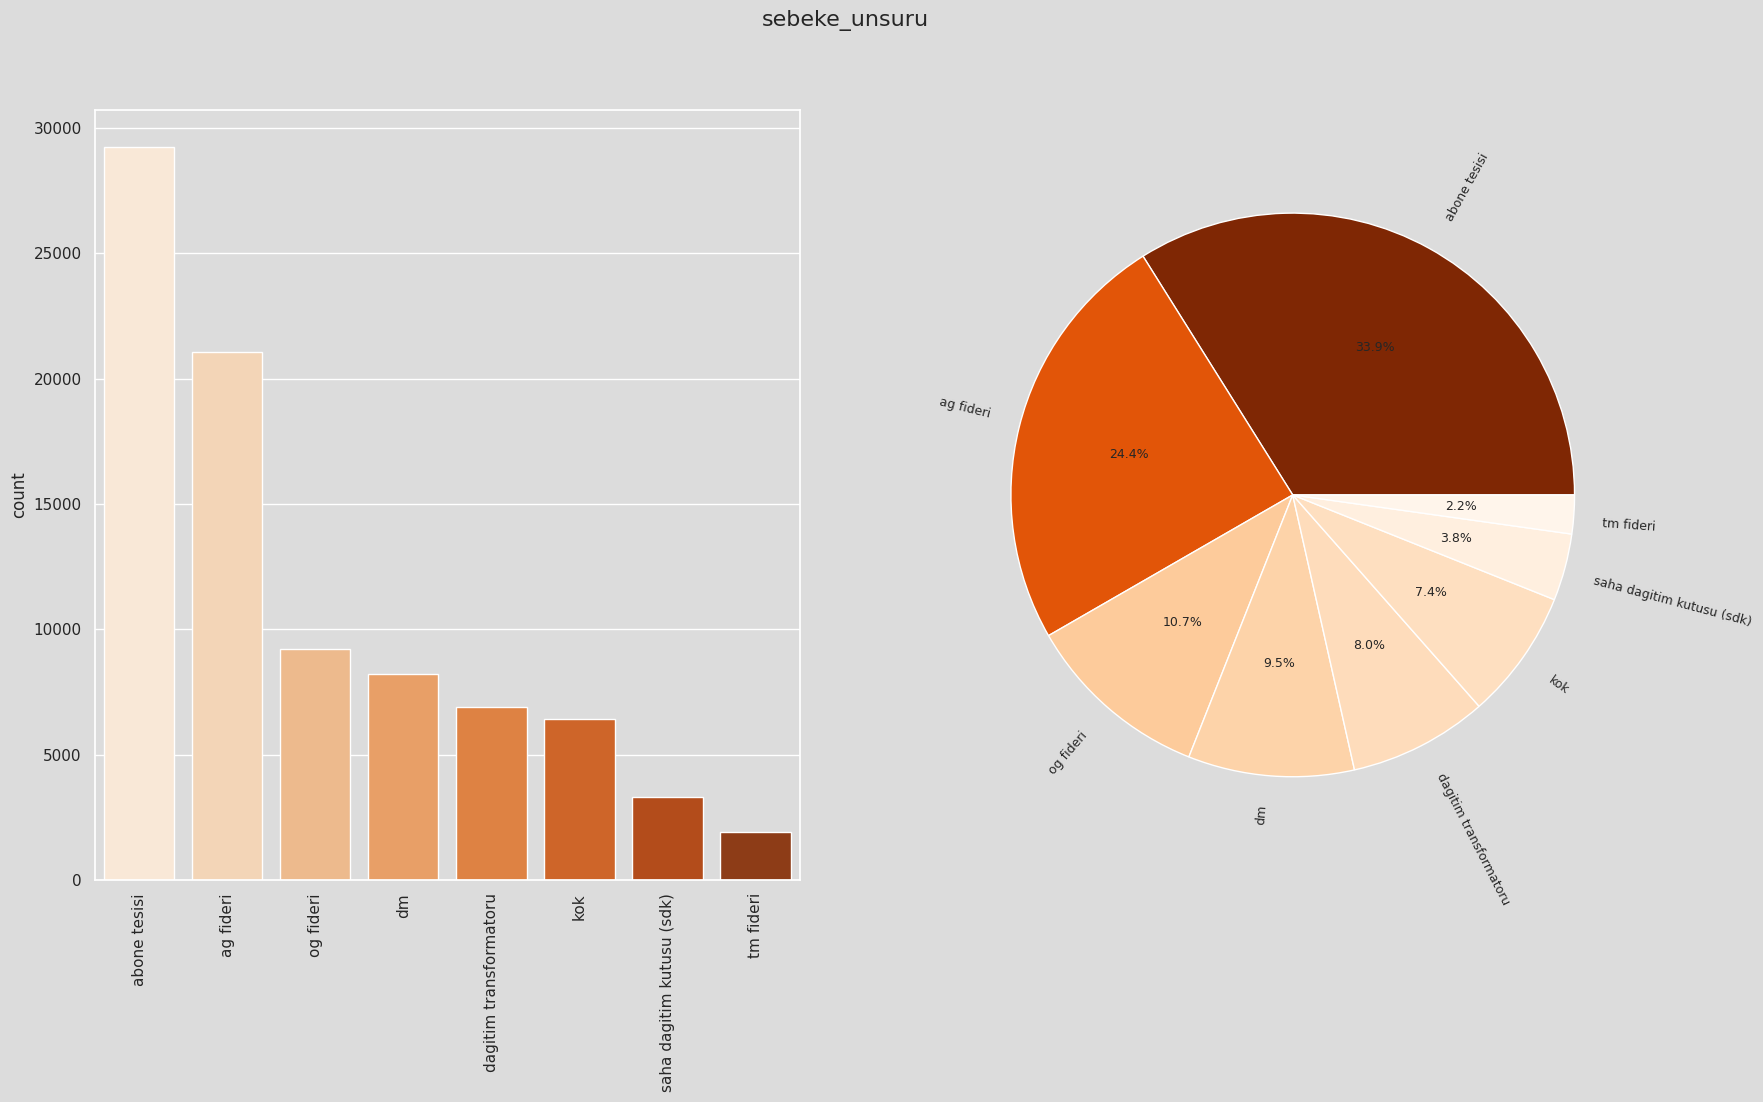

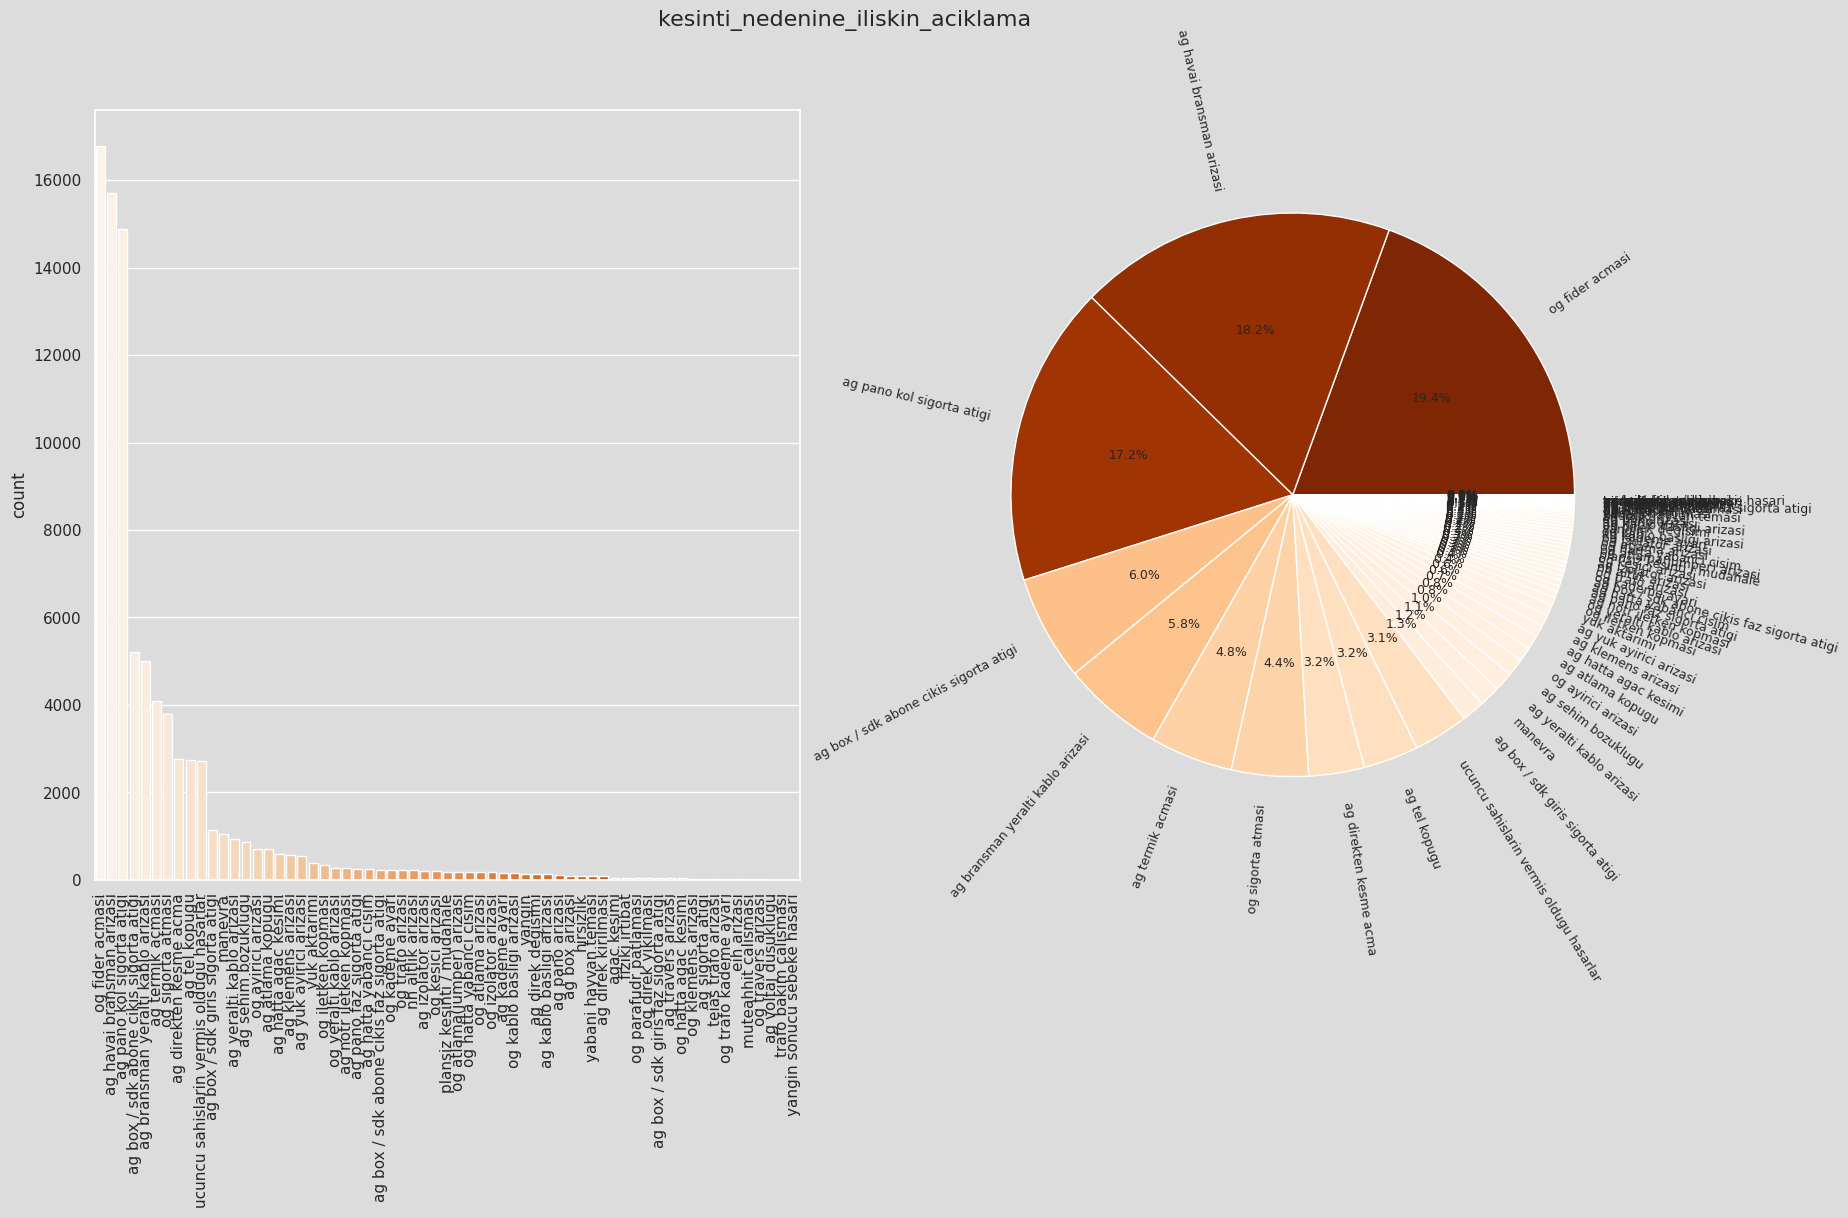

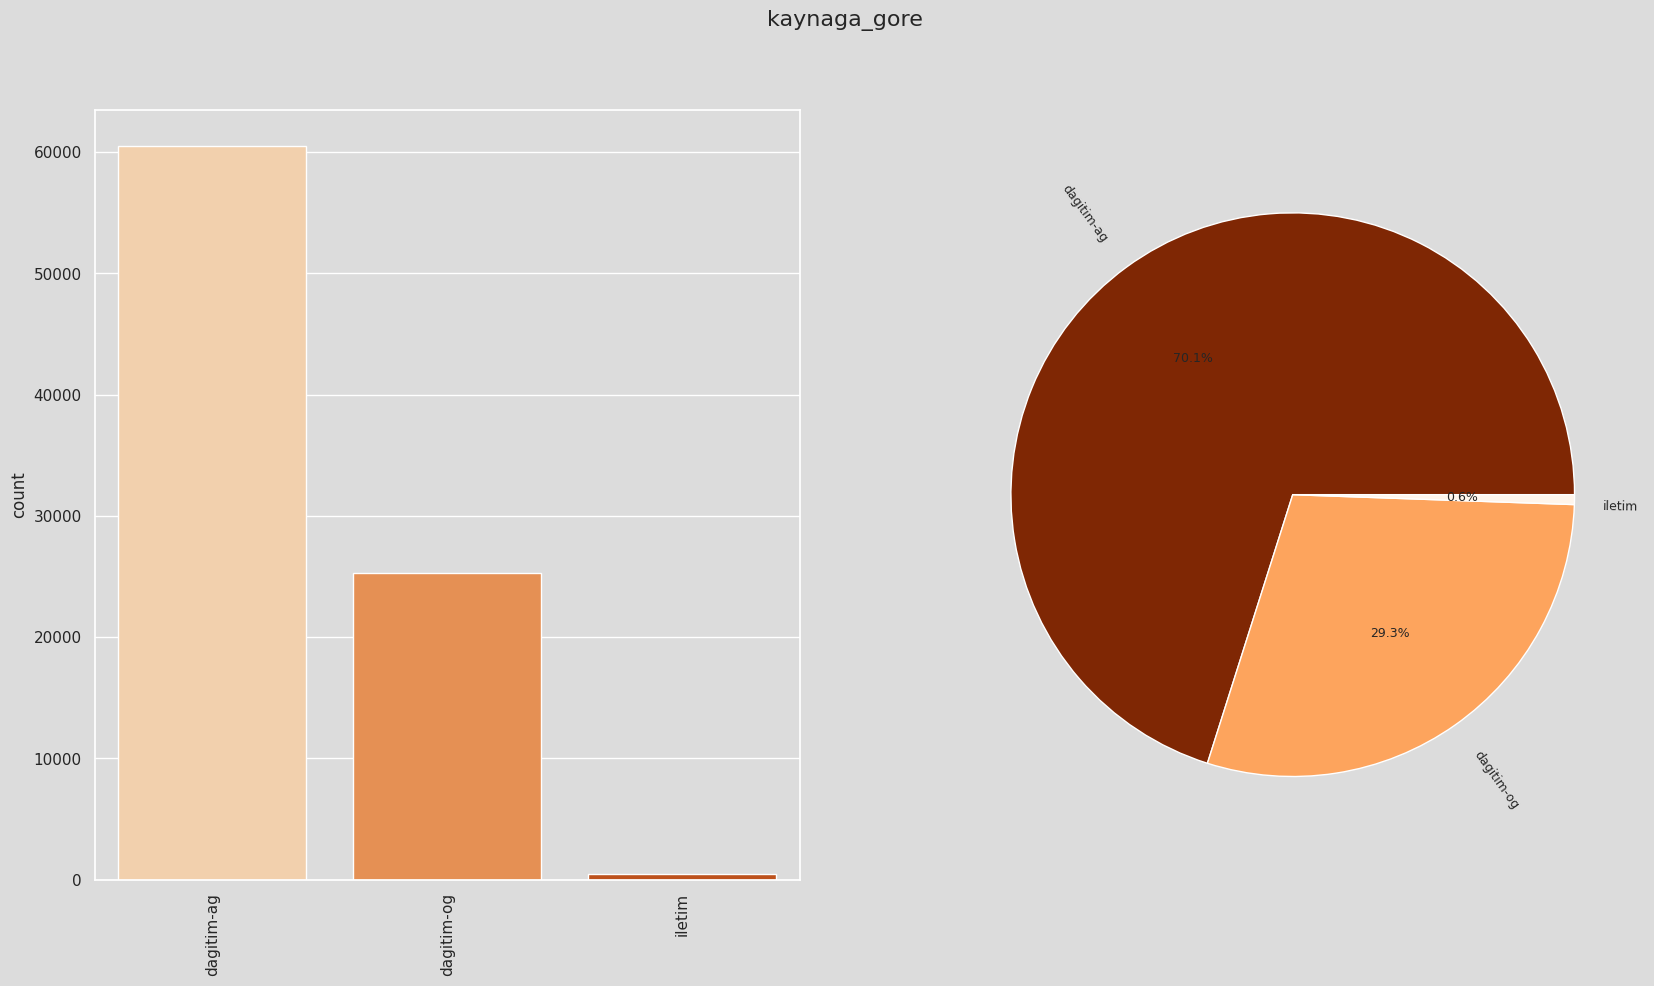

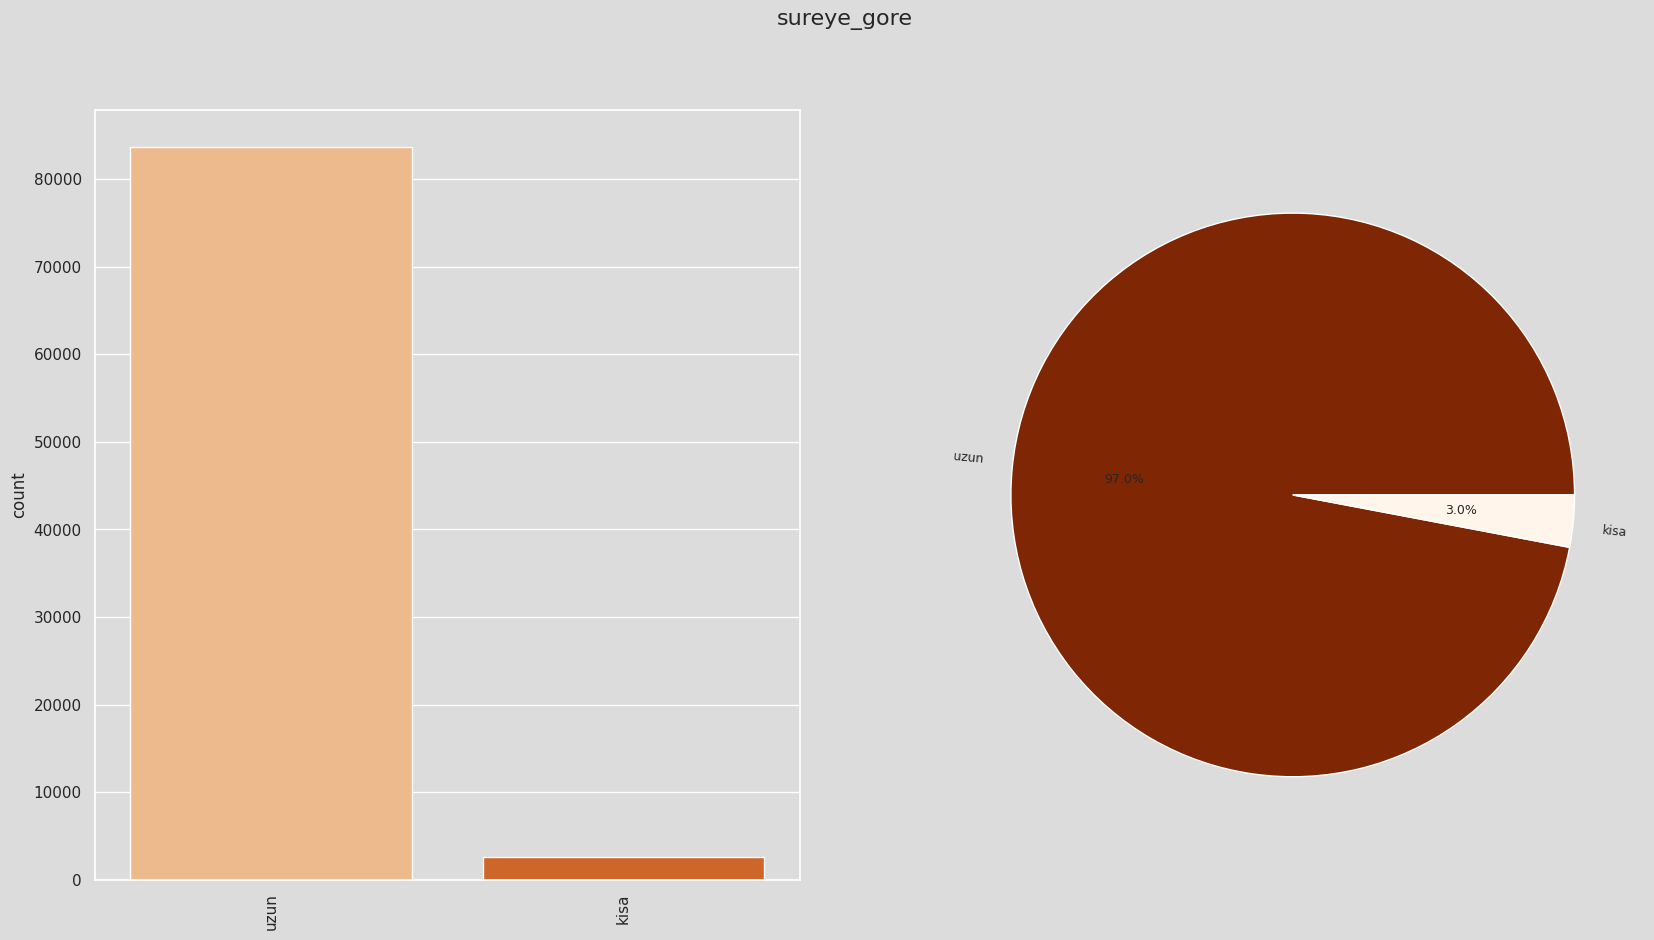

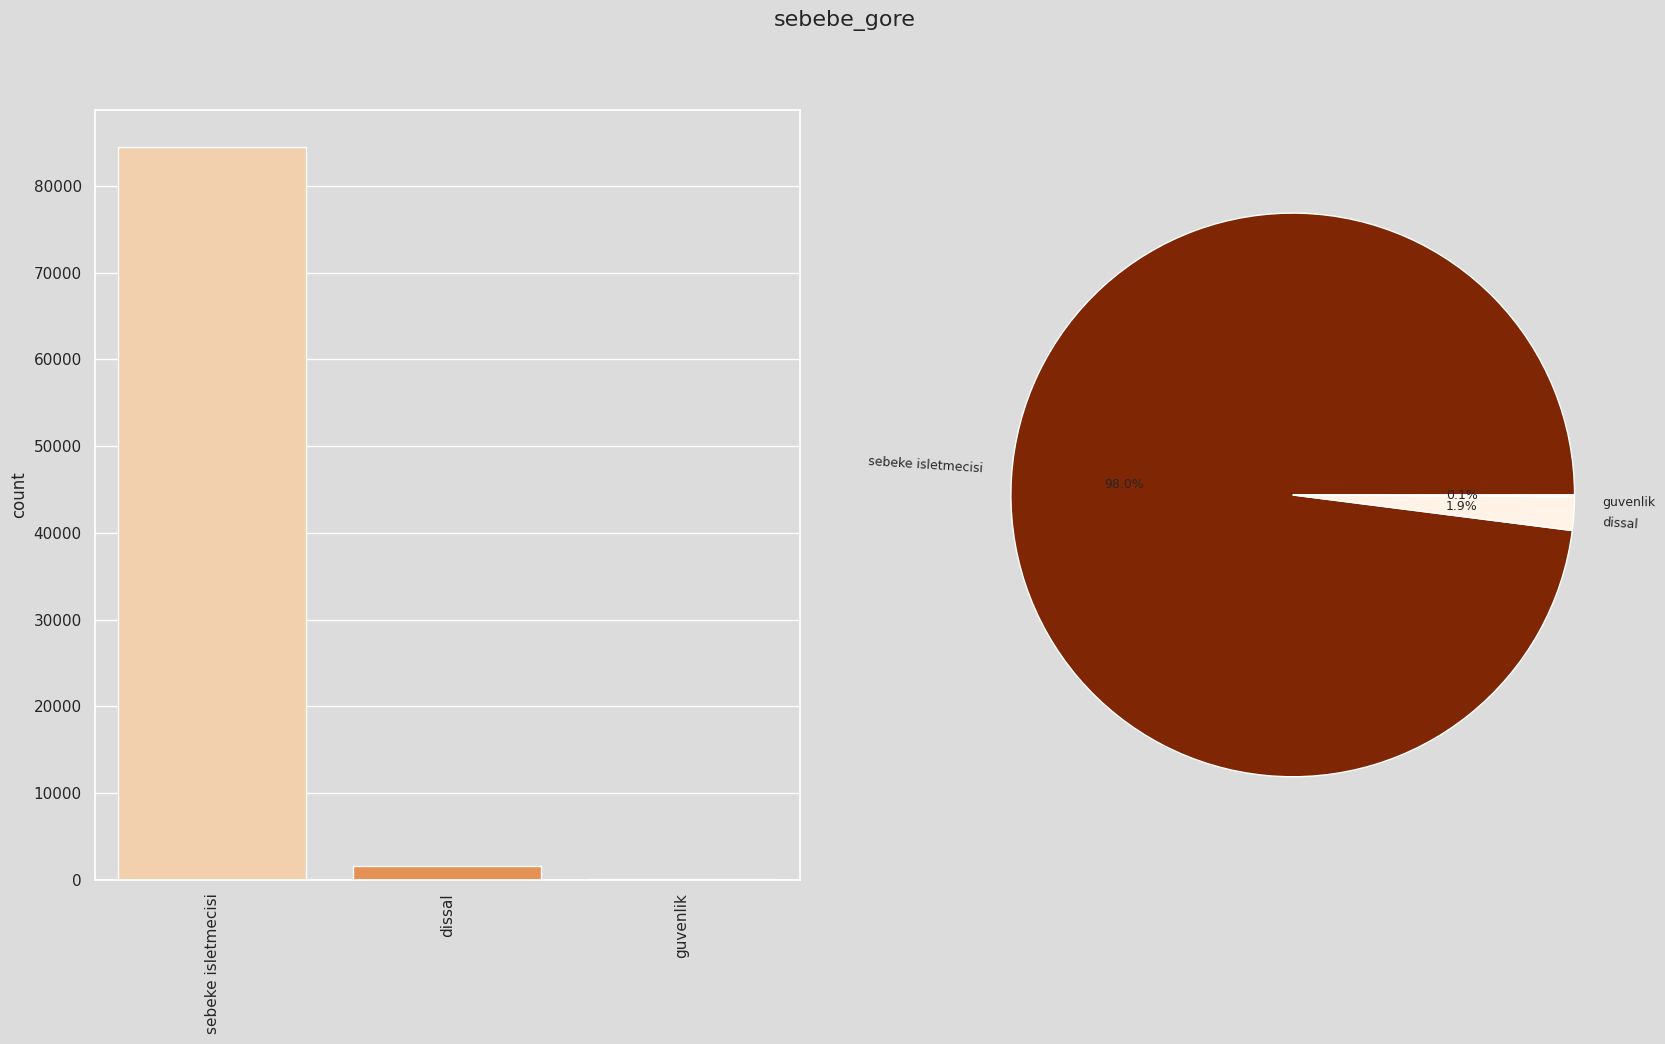

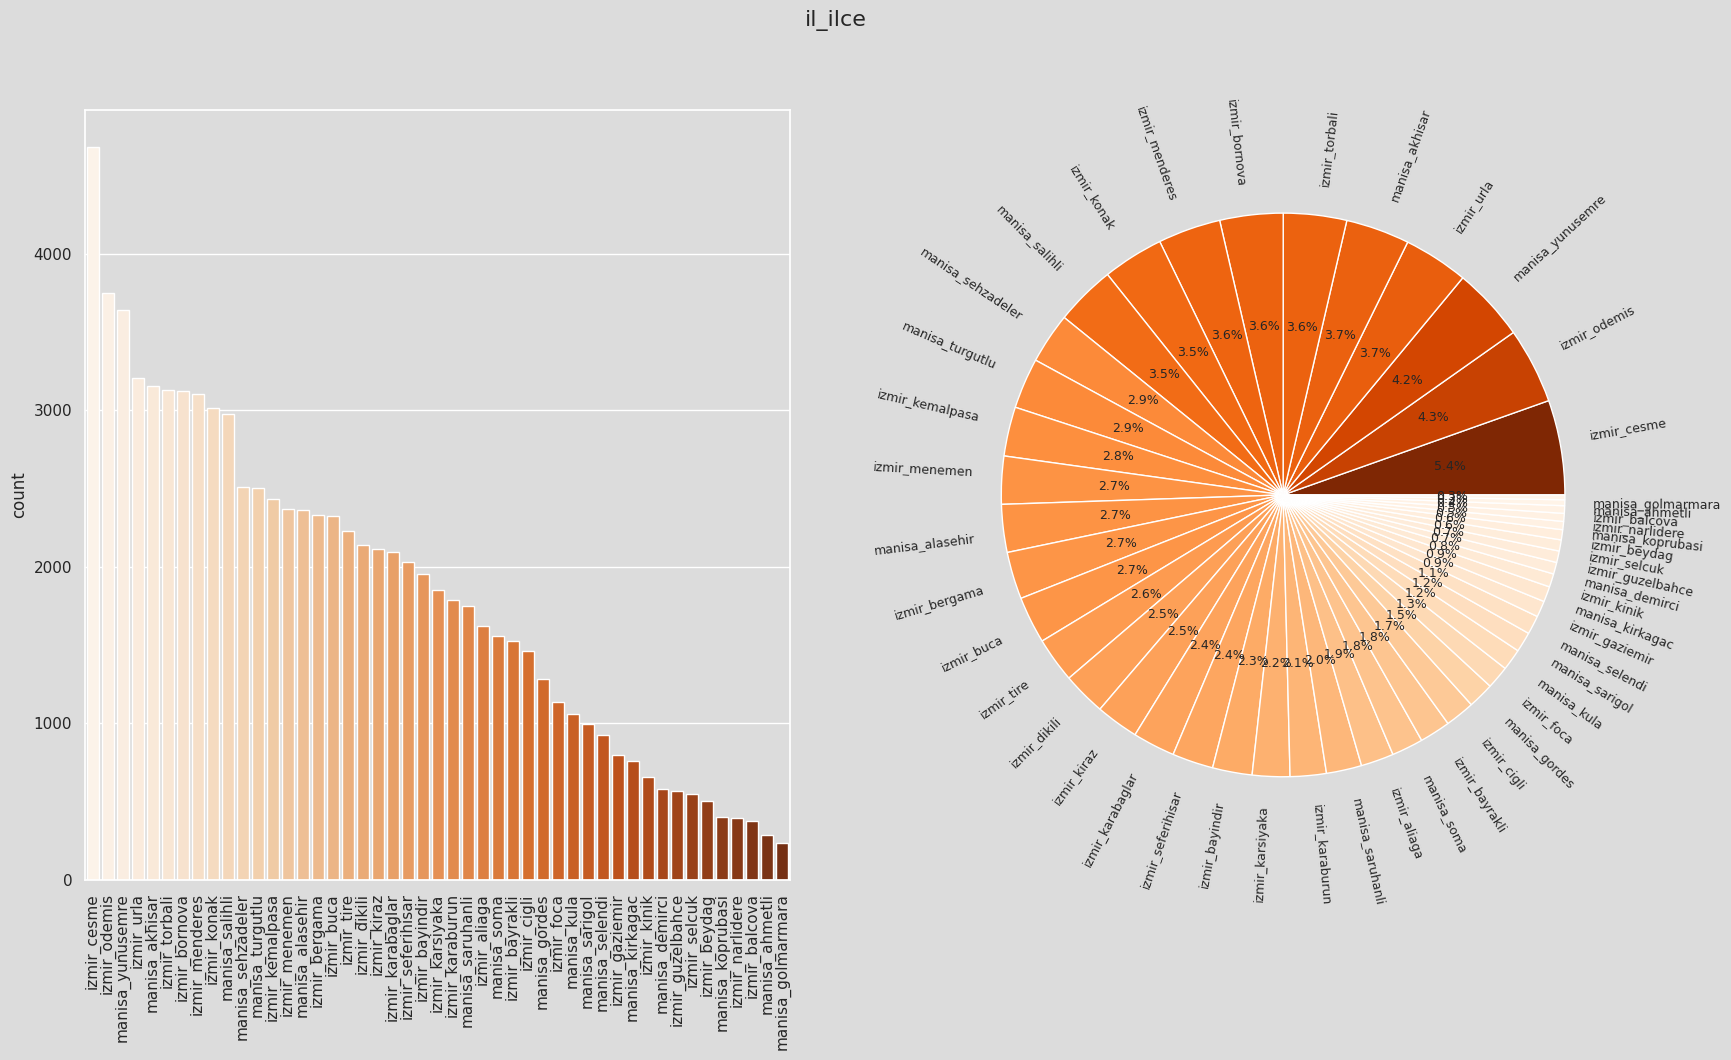

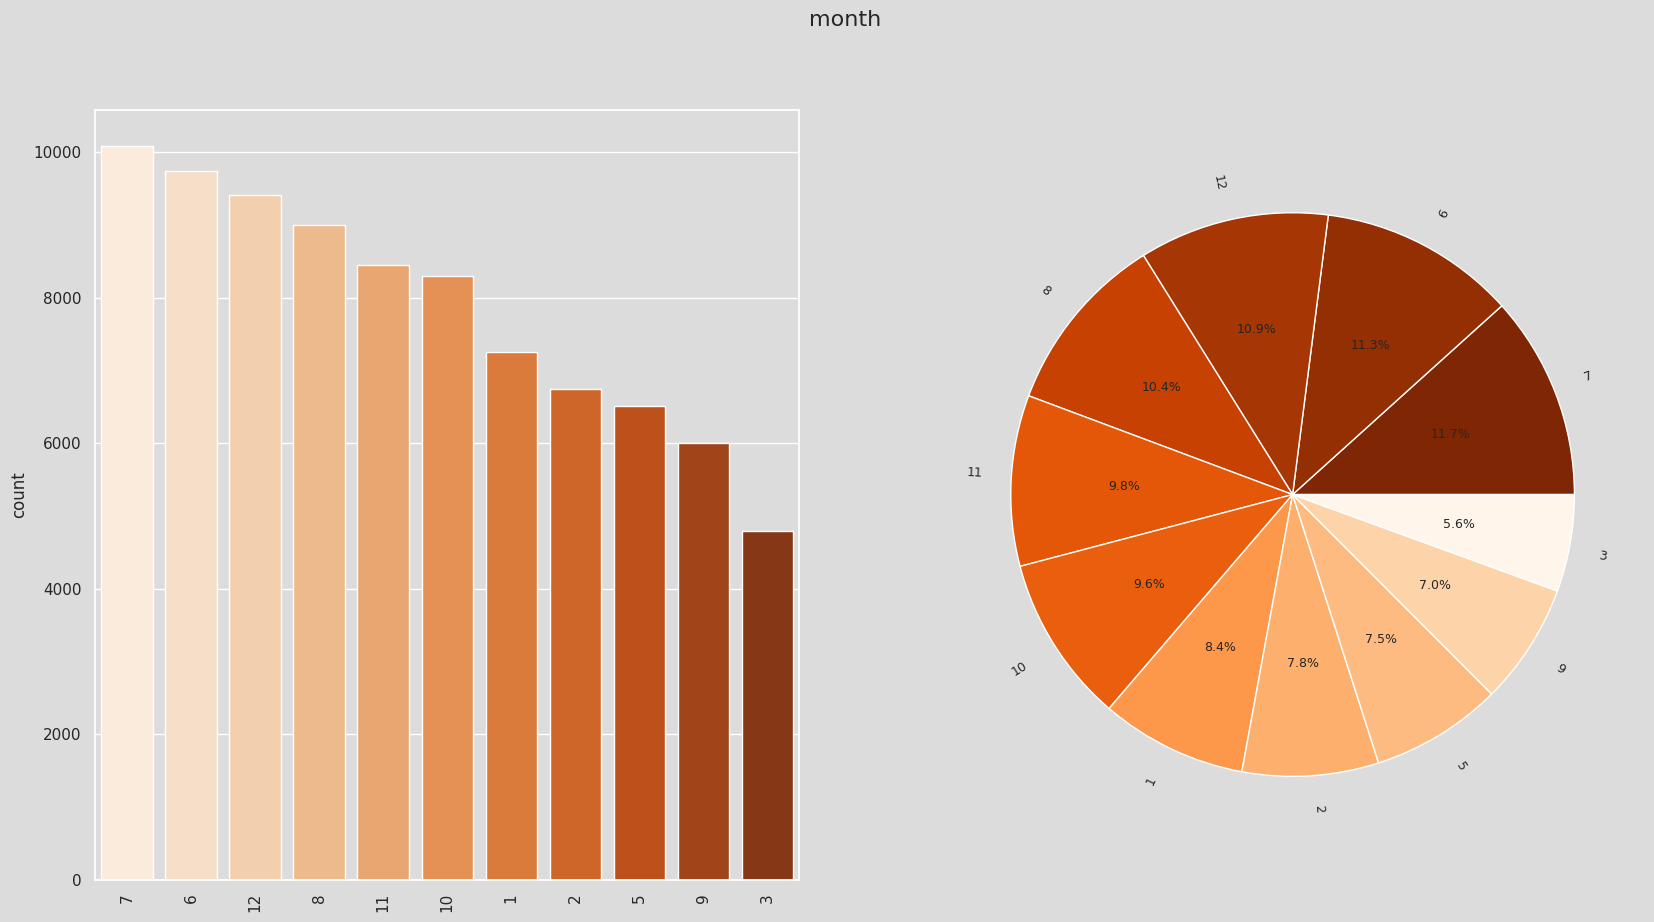

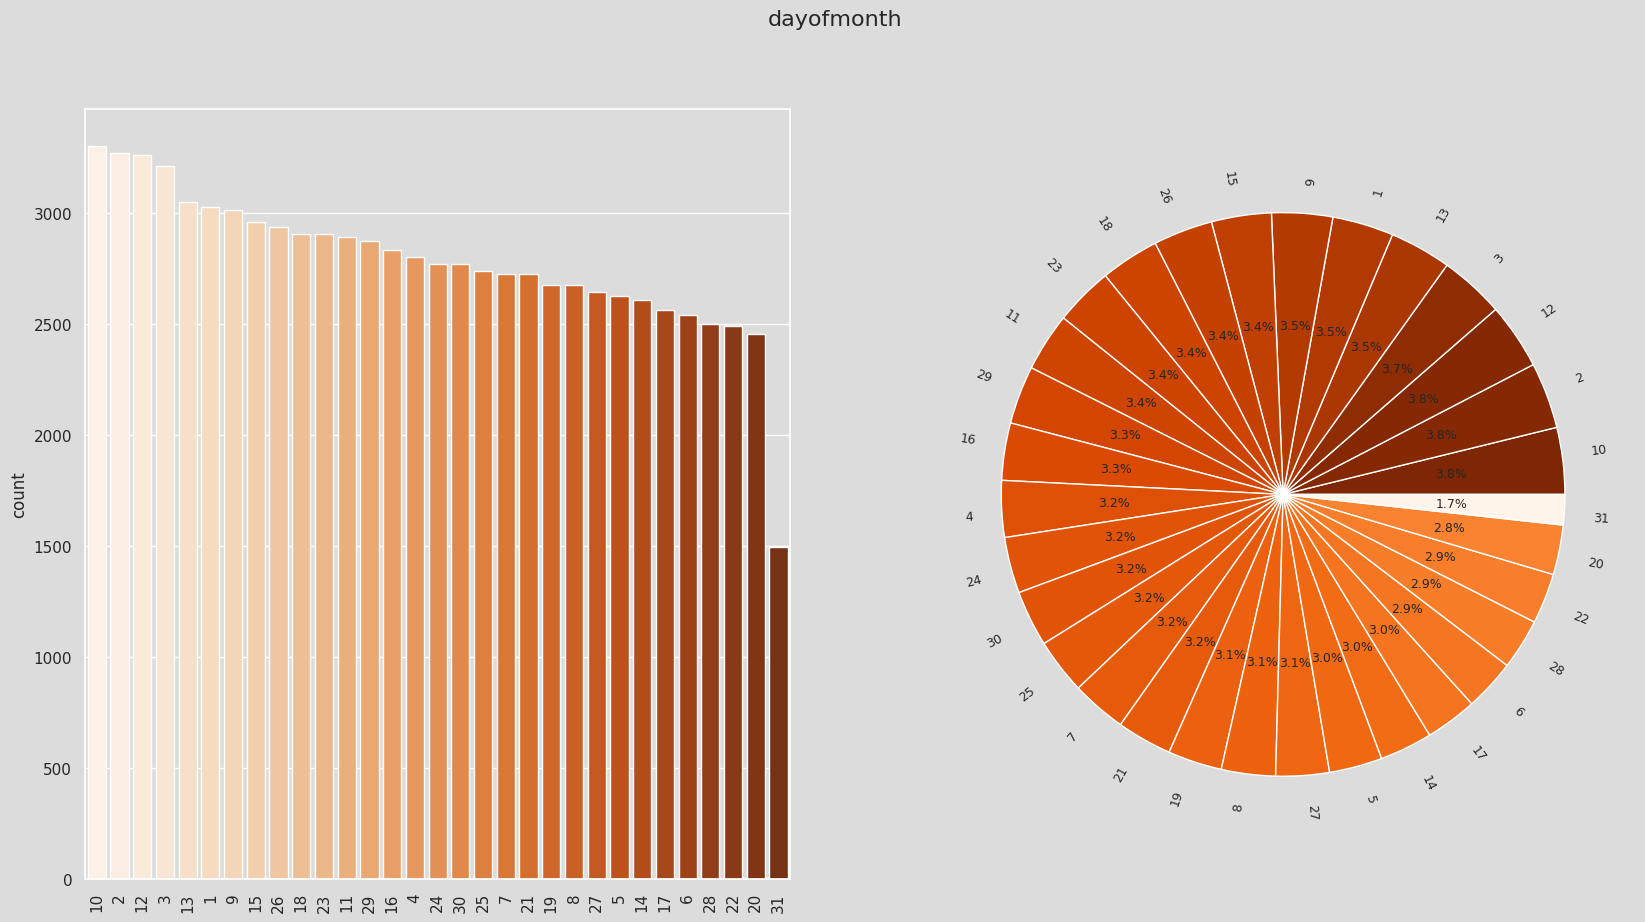

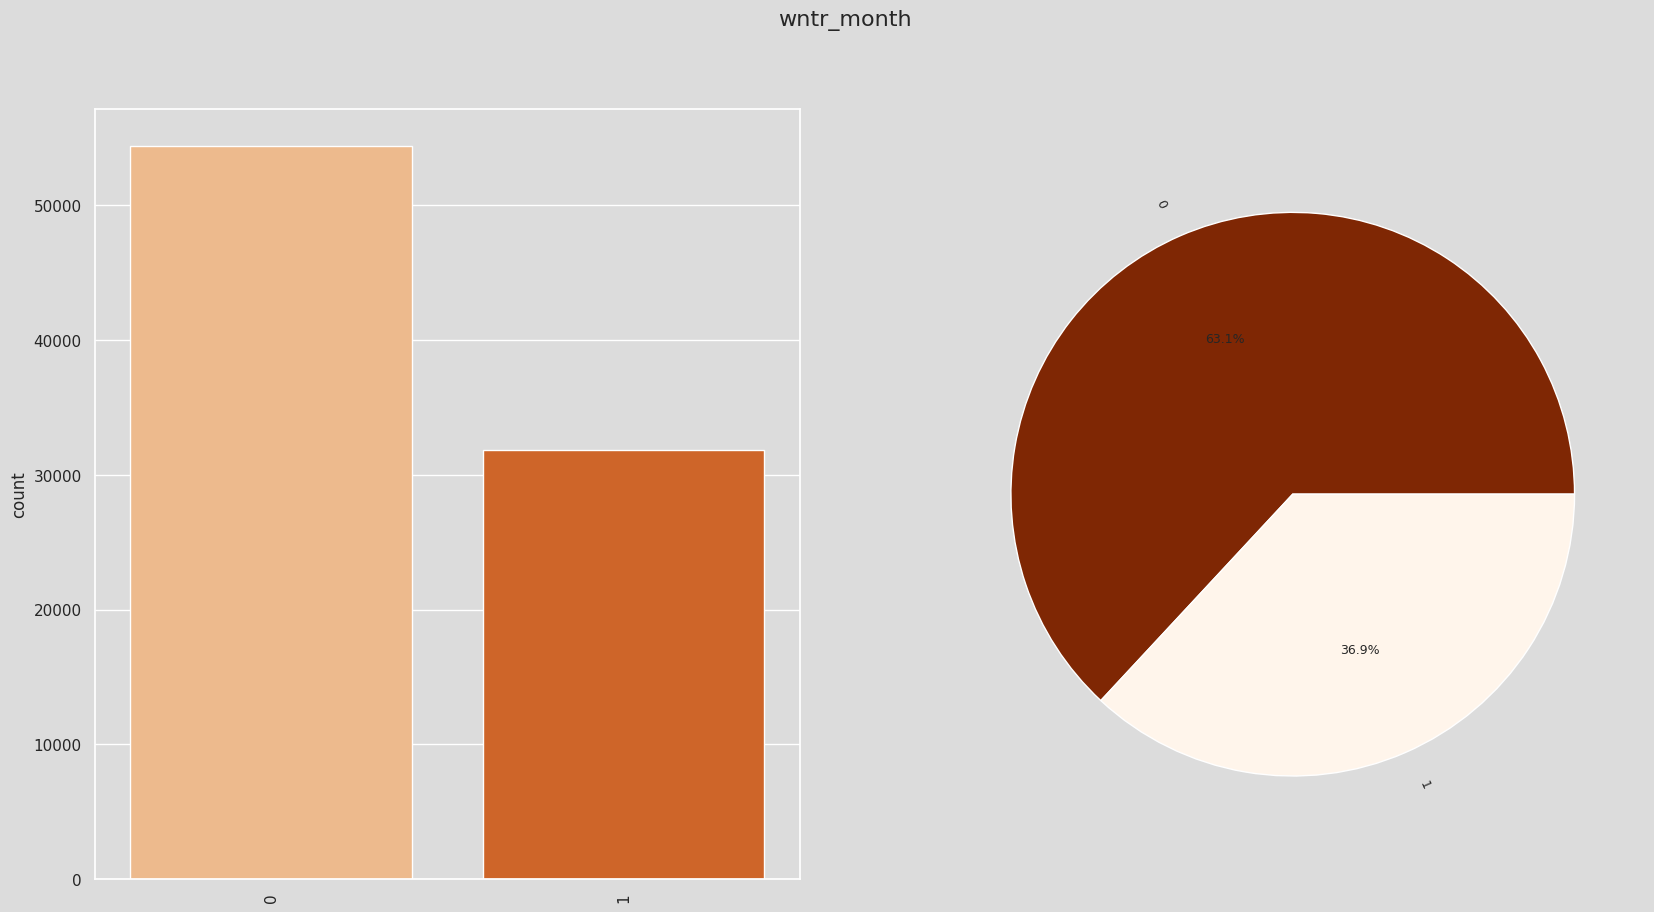

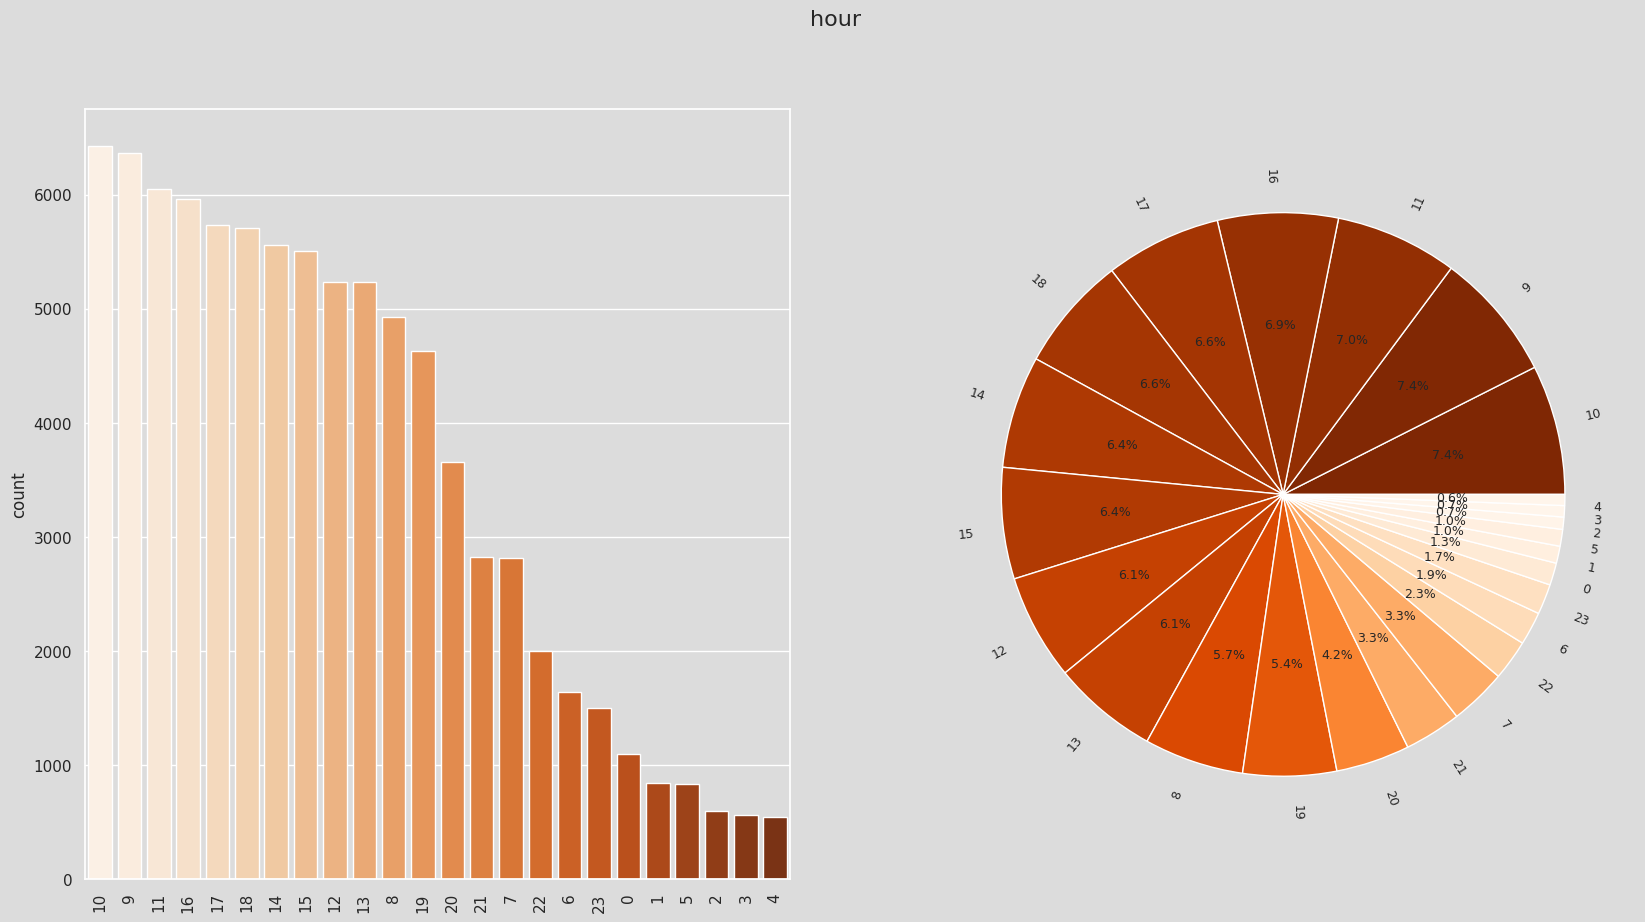

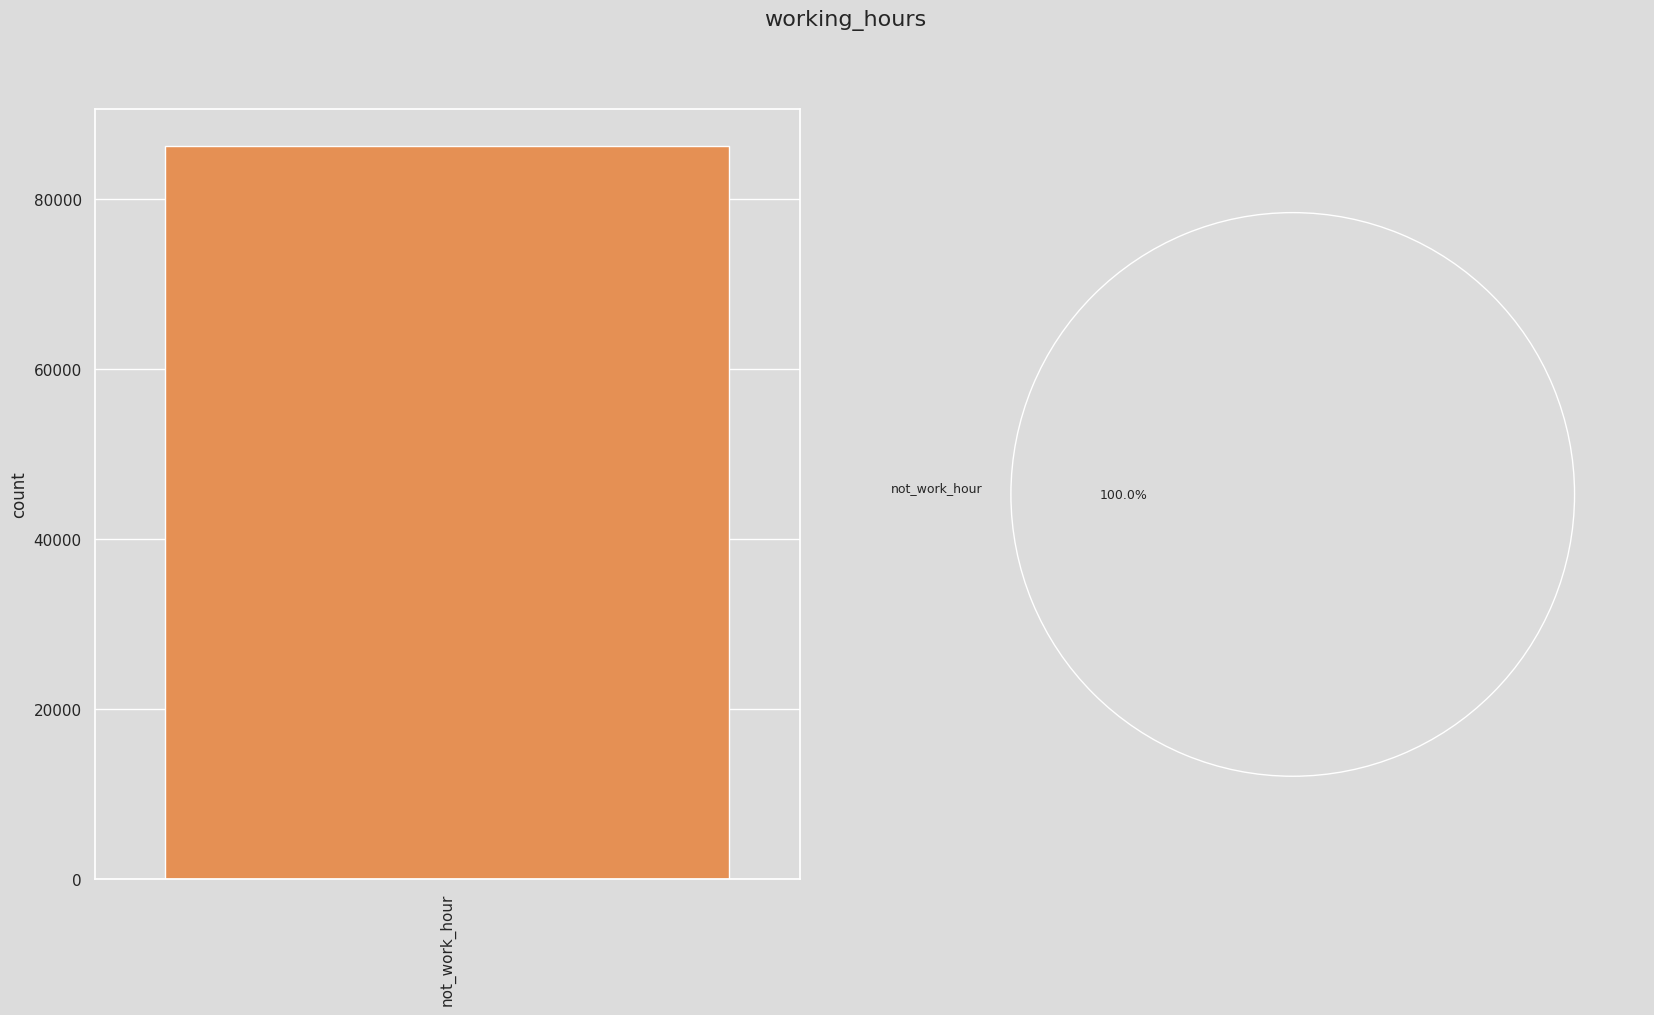

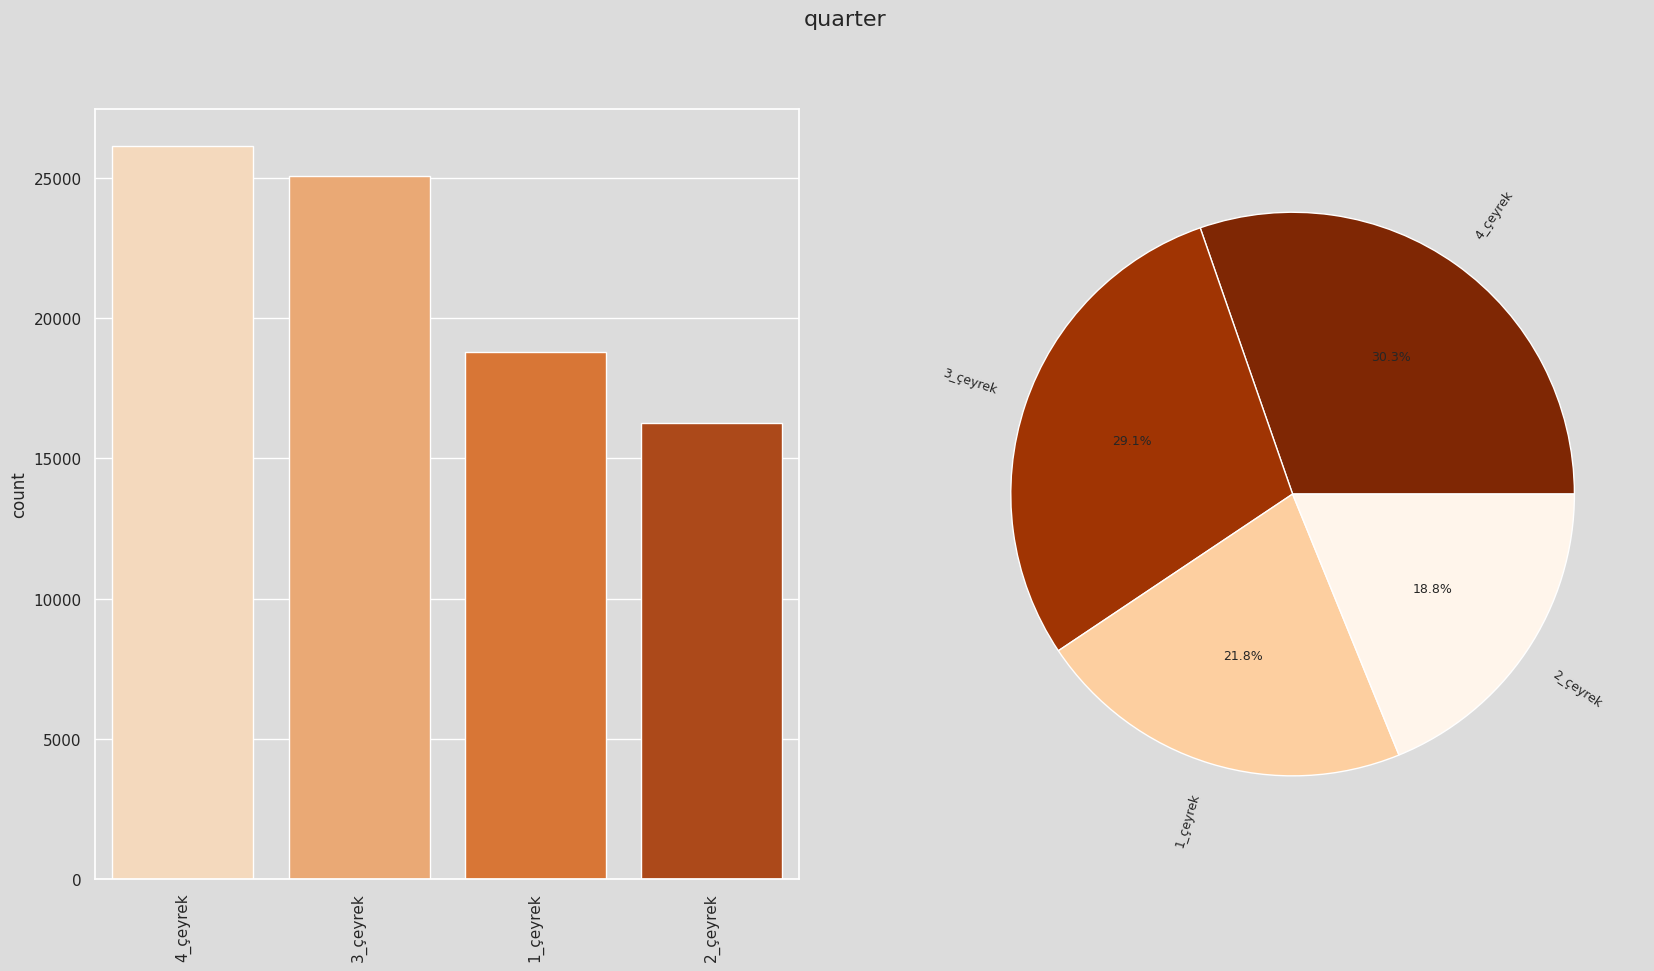

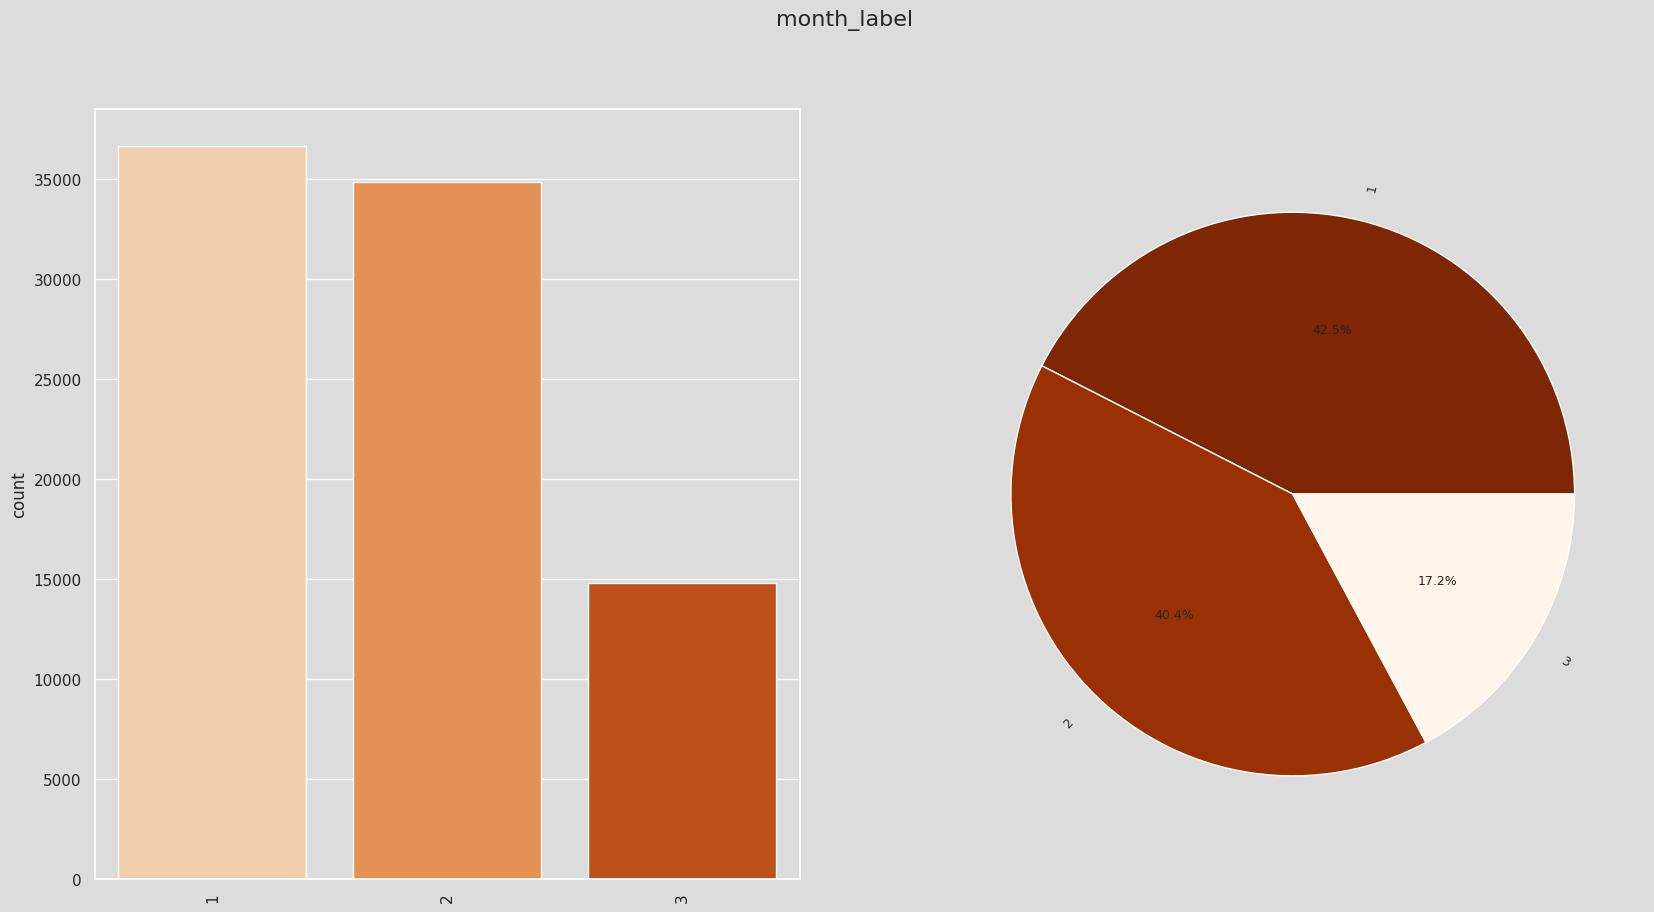

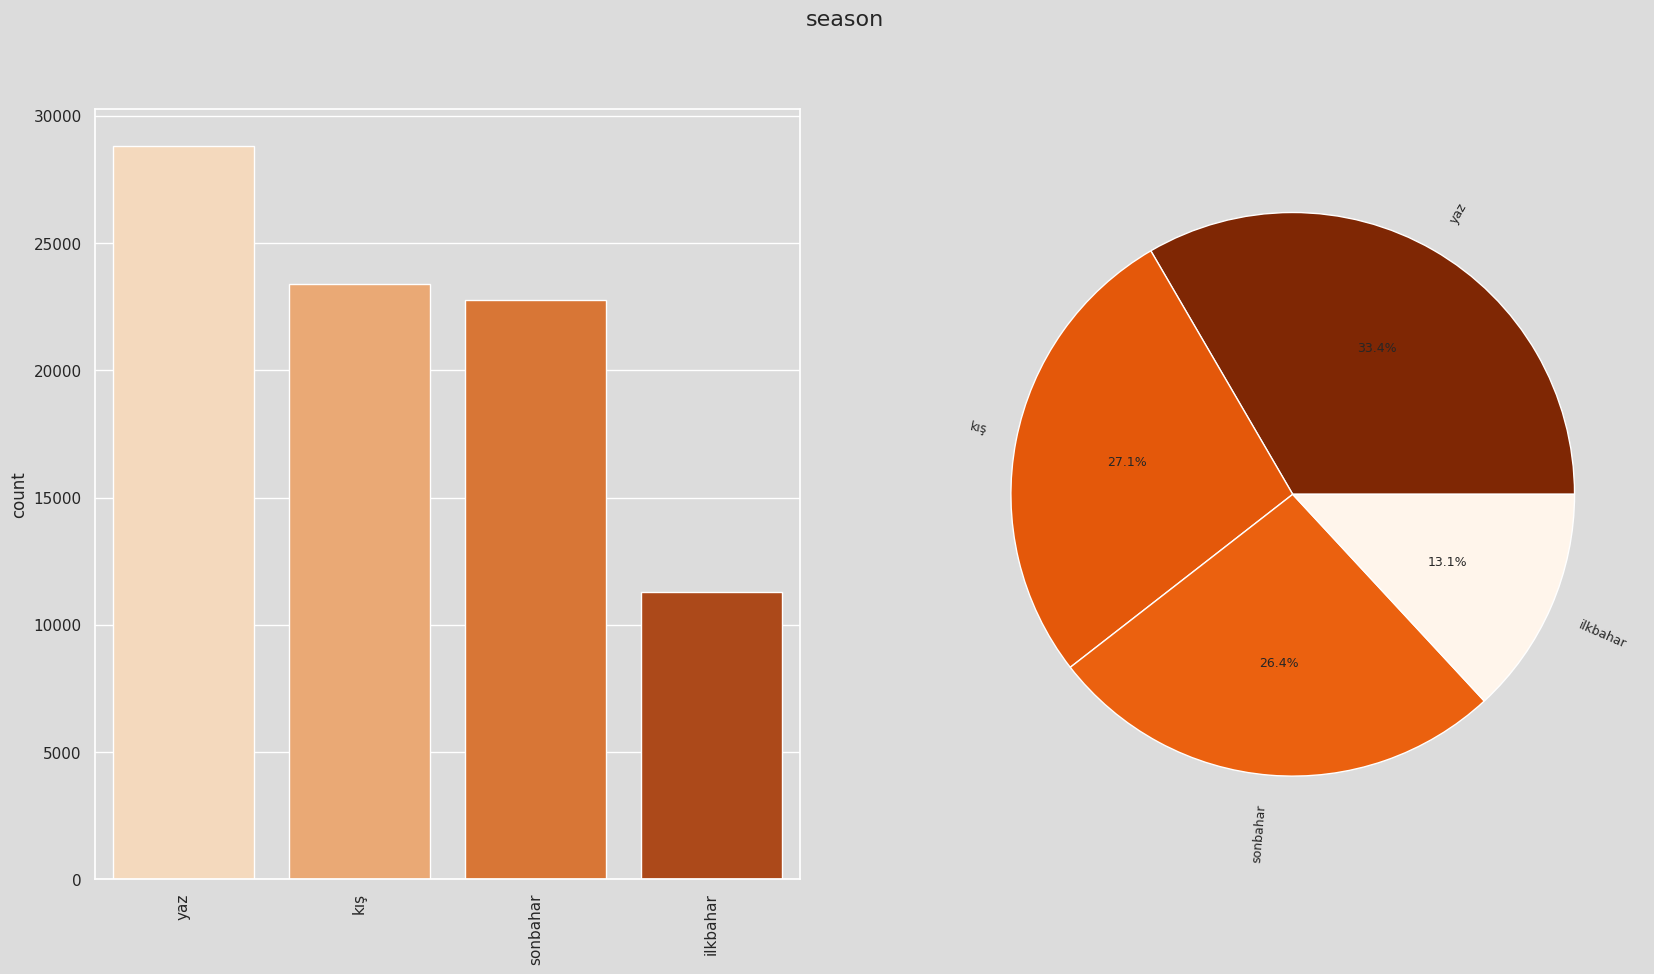

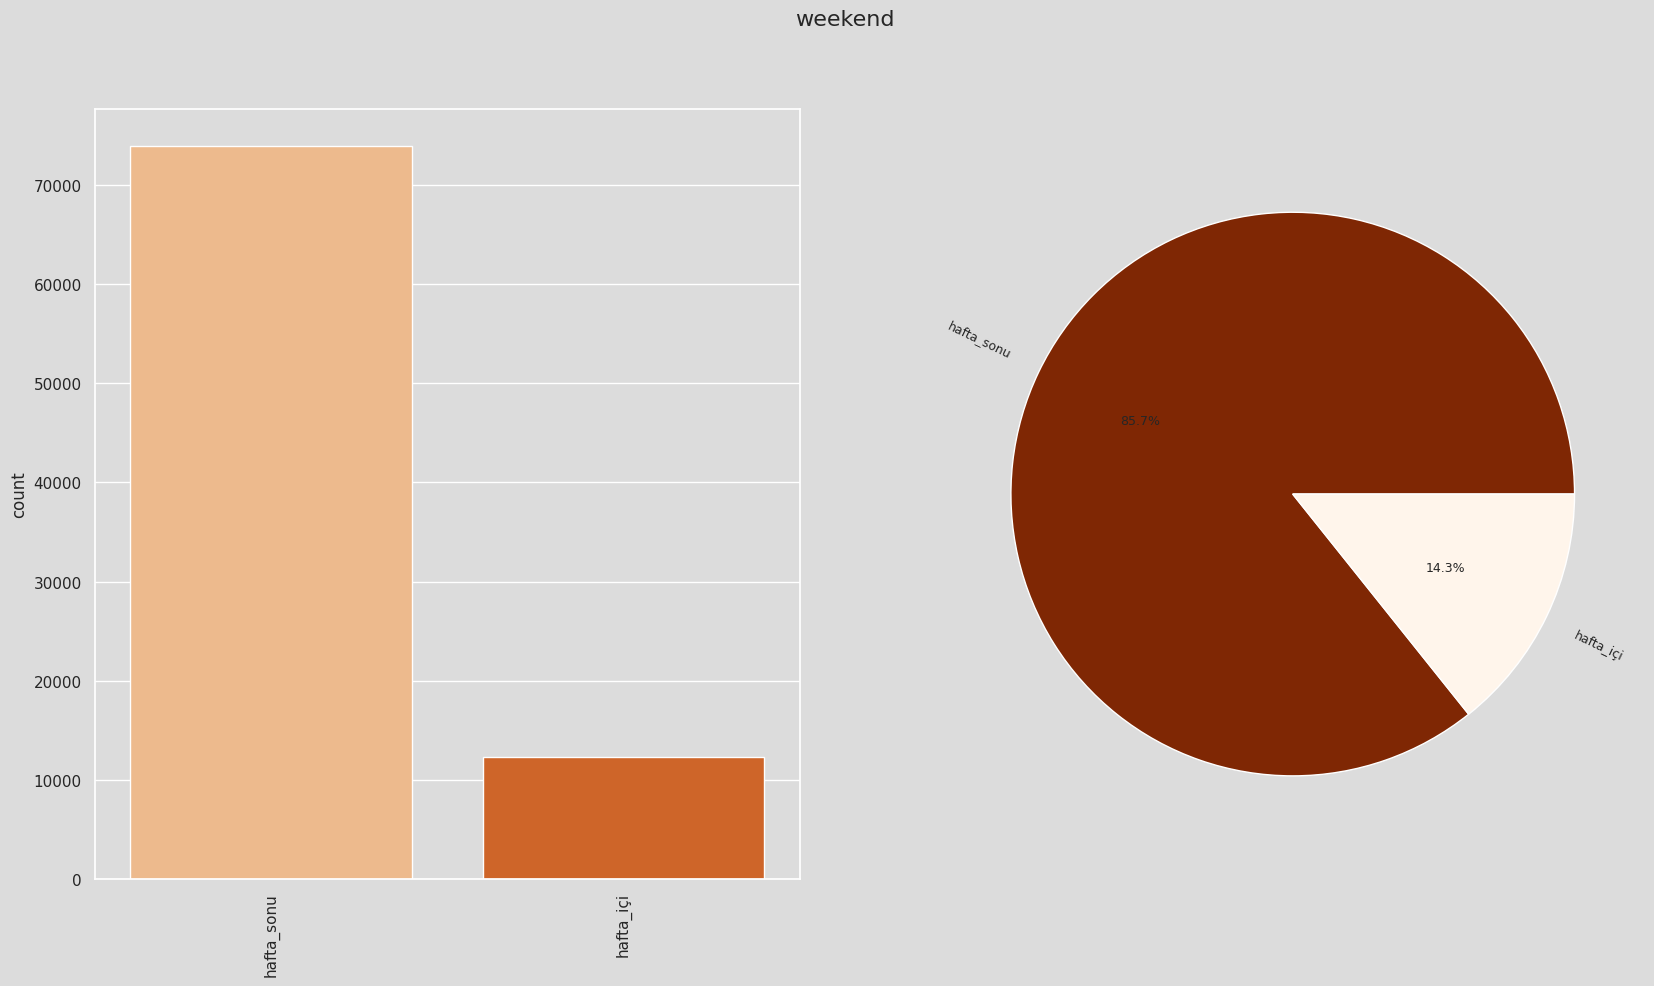

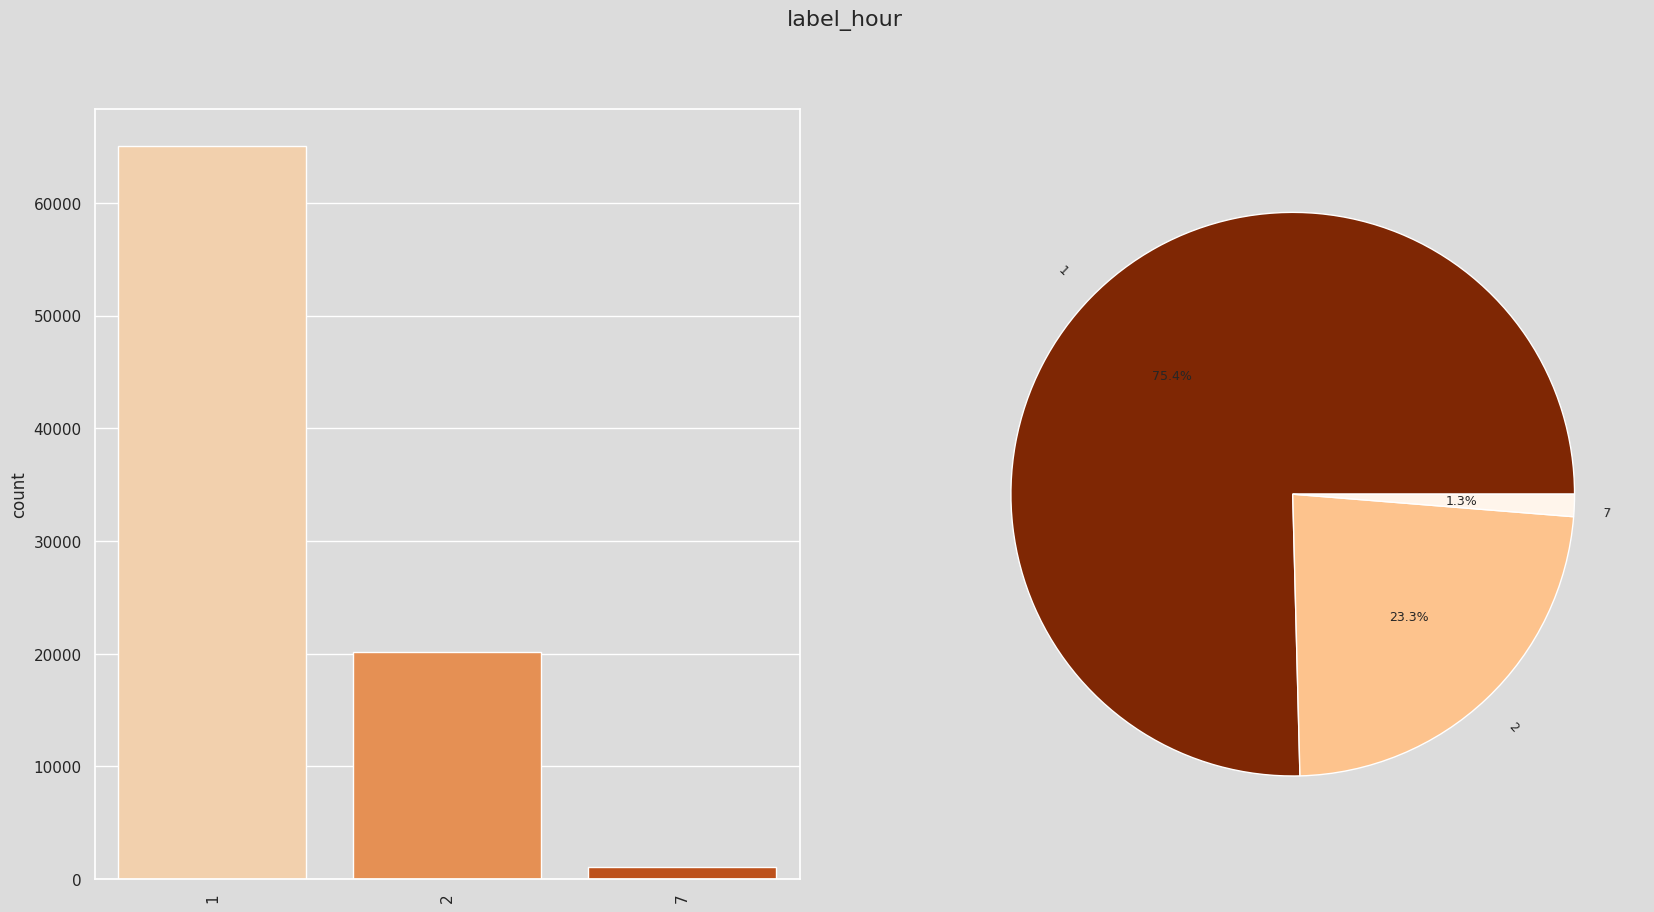

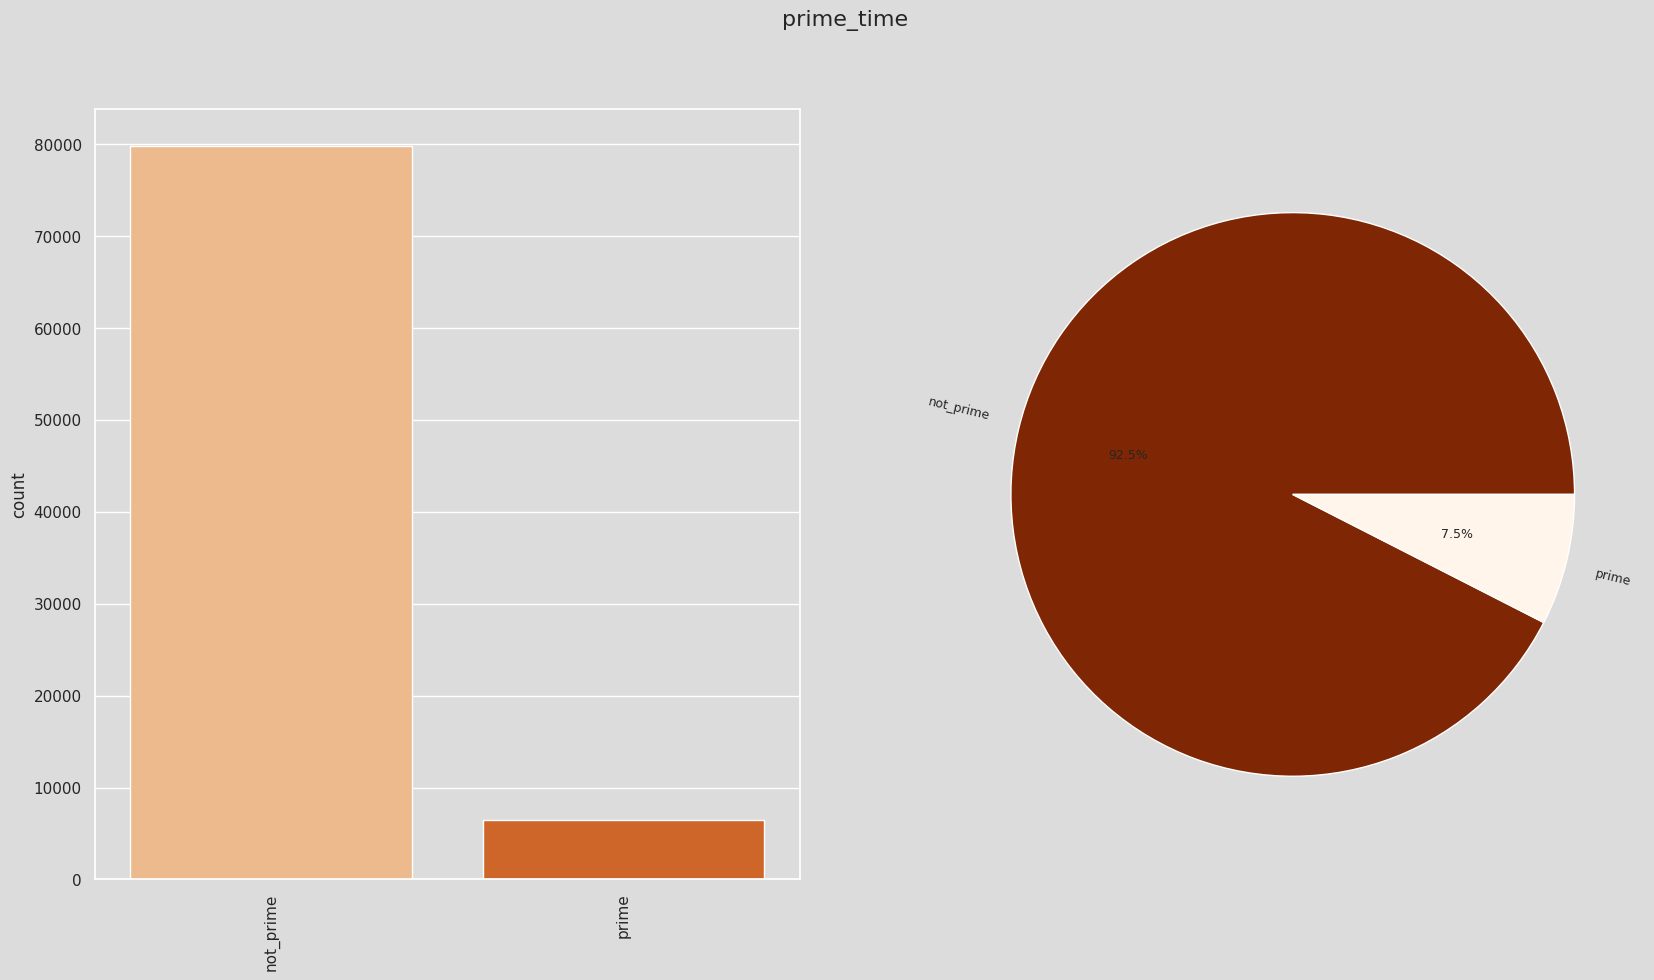

In [17]:
for col in obj_cols:
    cat_analyser(train, col)

### Feature Engineering

In [14]:
def feature_func(train_temp,test_temp,groupby_cols,features,agg_funcs='mean'):
    if type(agg_funcs)==str:
        agg_funcs=[agg_funcs]
    if type(features)==str:
        features=[features]
    if len(features)==1:
        for agg_func in agg_funcs:
            dum_temp=train_temp.groupby(groupby_cols).agg({col:agg_func for col in features}).reset_index().rename(columns={features[0]:'_'.join(groupby_cols)+'_'.join(features)+'_'+str(agg_func)})
            train_temp=train_temp.merge(dum_temp,on=groupby_cols,how='left').set_index(train_temp.index)
            test_temp=test_temp.merge(dum_temp,on=groupby_cols,how='left').set_index(test_temp.index)  
    else:
        trsh=1
        for agg_func in agg_funcs:
                dum_temp=train_temp.groupby(groupby_cols).agg({col:agg_func for col in features})
                dum_temp2=(dum_temp.cagri_count/dum_temp.iloc[:,:trsh].sum(axis=1)).reset_index().rename(columns={0:'_'.join(groupby_cols)+'_'.join(features)+'_'.join(agg_funcs)})
                train_temp=train_temp.merge(dum_temp2,on=groupby_cols,how='left').set_index(train_temp.index)
                test_temp=test_temp.merge(dum_temp2,on=groupby_cols,how='left').set_index(test_temp.index)
                
    return train_temp,test_temp


for  agg_func in ['mean','sum','max','min','std','median','count']:
        groupby_cols=['il','ilce']
        features=['cagri_count']
        train,test=feature_func(train,test,groupby_cols,features,agg_func)
        
for  agg_func in ['mean','sum','max','min','std','median','count']:
        groupby_cols=['sebeke_unsuru','sebebe_gore']
        features=['cagri_count']
        train,test=feature_func(train,test,groupby_cols,features,agg_func)


# groupby_cols=['sebeke_unsuru','kesinti_nedenine_iliskin_aciklama','kaynaga_gore','sureye_gore','sebebe_gore']
# features=['kentsel_og','kentsel_ag','kentalti_og','kentalti_ag','kirsal_og','kirsal_ag','cagri_count']
# train,test=feature_func(train,test,groupby_cols,features,['sum'])

# groupby_cols=['sebeke_unsuru','kesinti_nedenine_iliskin_aciklama','kaynaga_gore','sureye_gore','sebebe_gore']
# features=['toplam_kentsel_ag','toplam_kentalti_og','toplam_kentalti_ag','toplam_kirsal_og','toplam_kirsal_ag','cagri_count']
# train,test=feature_func(train,test,groupby_cols,features,['sum'])

# groupby_cols=['sebeke_unsuru','kesinti_nedenine_iliskin_aciklama']
# features=['kentsel_og','kentsel_ag','kentalti_og','kentalti_ag','kirsal_og','kirsal_ag','cagri_count']
# train,test=feature_func(train,test,groupby_cols,features,['sum'])

# groupby_cols=['sebeke_unsuru','kesinti_nedenine_iliskin_aciklama']
# features=['toplam_kentsel_ag','toplam_kentalti_og','toplam_kentalti_ag','toplam_kirsal_og','toplam_kirsal_ag','cagri_count']
# train,test=feature_func(train,test,groupby_cols,features,['sum'])

# groupby_cols=['kaynaga_gore','sureye_gore','sebebe_gore']
# features=['kentsel_og','kentsel_ag','kentalti_og','kentalti_ag','kirsal_og','kirsal_ag','cagri_count']
# train,test=feature_func(train,test,groupby_cols,features,['sum'])

# groupby_cols=['kaynaga_gore','sureye_gore','sebebe_gore']
# features=['toplam_kentsel_ag','toplam_kentalti_og','toplam_kentalti_ag','toplam_kirsal_og','toplam_kirsal_ag','cagri_count']
# train,test=feature_func(train,test,groupby_cols,features,['sum'])

# ---------------------
groupby_cols=['il','ilce']
features=['kentsel_og','kentsel_ag','cagri_count']
train,test=feature_func(train,test,groupby_cols,features,['sum'])

groupby_cols=['il','ilce']
features=['kentalti_og','kentalti_ag','cagri_count']
train,test=feature_func(train,test,groupby_cols,features,['sum'])

groupby_cols=['il','ilce']
features=['kirsal_og','kirsal_ag','cagri_count']
train,test=feature_func(train,test,groupby_cols,features,['sum'])

groupby_cols=['il','ilce']
features=['toplam_kentsel_og','toplam_kentsel_ag','cagri_count']
train,test=feature_func(train,test,groupby_cols,features,['sum'])

groupby_cols=['il','ilce']
features=['toplam_kentalti_og','toplam_kentalti_ag','cagri_count']
train,test=feature_func(train,test,groupby_cols,features,['sum'])

groupby_cols=['il','ilce']
features=['toplam_kirsal_og','toplam_kirsal_ag','cagri_count']
train,test=feature_func(train,test,groupby_cols,features,['sum'])

# -----------------------
groupby_cols=['il','ilce','sebeke_unsuru']
features=['kentsel_og','kentalti_og','kirsal_og','cagri_count']
train,test=feature_func(train,test,groupby_cols,features,['sum'])

groupby_cols=['il','ilce','sebeke_unsuru']
features=['kentsel_ag','kentalti_ag','kirsal_ag','cagri_count']
train,test=feature_func(train,test,groupby_cols,features,['sum'])


# groupby_cols=['il','ilce','sebeke_unsuru']
# features=['toplam_kentsel_og','toplam_kentalti_og','toplam_kirsal_og','cagri_count']
# train,test=feature_func(train,test,groupby_cols,features,['sum'])

# groupby_cols=['il','ilce','sebeke_unsuru']
# features=['toplam_kentsel_ag','toplam_kentalti_ag','toplam_kirsal_ag','cagri_count']
# train,test=feature_func(train,test,groupby_cols,features,['sum'])

# -------------------------------------------------

dum=train.groupby(['il','ilce']).agg({'kentsel_og':'mean','kentsel_ag':'mean','kentalti_og':'mean','kentalti_ag':'mean','kirsal_og':'mean','kirsal_ag':'mean'})
dum.columns=['kentsel_og_mean','kentsel_ag_mean','kentalti_og_mean','kentalti_ag_mean','kirsal_og_mean','kirsal_ag_mean']

train=train.merge(dum,on=['il','ilce'],how='left').set_index(train.index)
test=test.merge(dum,on=['il','ilce'],how='left').set_index(test.index)


dum=train.groupby(['il','ilce']).agg({'toplam_kentsel_og':'mean','toplam_kentsel_ag':'mean','toplam_kentalti_og':'mean','toplam_kentalti_ag':'mean','toplam_kirsal_og':'mean','toplam_kirsal_ag':'mean'})
dum.columns=['Toplam_kentsel_og_mean','toplam_kentsel_ag_mean','toplam_kentalti_og_mean','toplam_kentalti_ag_mean','toplam_kirsal_og_mean','toplam_kirsal_ag_mean']
train=train.merge(dum,on=['il','ilce'],how='left').set_index(train.index)
test=test.merge(dum,on=['il','ilce'],how='left').set_index(test.index)


dum=train.groupby(['il','ilce']).agg({'kentsel_og':'sum','kentsel_ag':'sum','kentalti_og':'sum','kentalti_ag':'sum','kirsal_og':'sum','kirsal_ag':'sum'})
dum.columns=['kentsel_og_sum','kentsel_ag_sum','kentalti_og_sum','kentalti_ag_sum','kirsal_og_sum','kirsal_ag_sum']
train=train.merge(dum,on=['il','ilce'],how='left').set_index(train.index)
test=test.merge(dum,on=['il','ilce'],how='left').set_index(test.index)


dum=train.groupby(['il','ilce']).agg({'toplam_kentsel_og':'sum','toplam_kentsel_ag':'sum','toplam_kentalti_og':'sum','toplam_kentalti_ag':'sum','toplam_kirsal_og':'sum','toplam_kirsal_ag':'sum'})
dum.columns=['Toplam_kentsel_og_sum','toplam_kentsel_ag_sum','toplam_kentalti_og_sum','toplam_kentalti_ag_sum','toplam_kirsal_og_sum','toplam_kirsal_ag_sum']
train=train.merge(dum,on=['il','ilce'],how='left').set_index(train.index)
test=test.merge(dum,on=['il','ilce'],how='left').set_index(test.index)

# -------------------------------------------------

train,test=cat_target_encode(train,test,'cagri_count',[ 'ilce','sebebe_gore'])
train,test=cat_target_encode(train,test,'cagri_count',[ 'ilce','season', 'weekend'])
train,test=cat_target_encode(train,test,'cagri_count',[ 'ilce','kaynaga_gore', 'sureye_gore'])
train,test=cat_target_encode(train,test,'cagri_count',[ 'ilce','kaynaga_gore','sebebe_gore'])
train,test=cat_target_encode(train,test,'cagri_count',[ 'ilce','quarter','month'])
train,test=cat_target_encode(train,test,'cagri_count',['ilce','weekend','label_hour','prime_time'])

train=train.replace(np.inf,0)
test=test.replace(np.inf,0)

In [22]:
test[obj_cols]=test[obj_cols].astype(object)
display(test[obj_cols].describe())
display(test.describe())
print('train shape: {}'.format(train.shape))
print('test shape: {}'.format(test.shape))

il    ilce sebeke_unsuru kesinti_nedenine_iliskin_aciklama   
count   16751   16751         16751                             16751  \
unique      2      47             8                                61   
top     izmir  odemis  abone tesisi                   og fider acmasi   
freq    11111    1023          4613                              3747   

       kaynaga_gore sureye_gore         sebebe_gore       il_ilce  month   
count         16751       16751               16751         16751  16751  \
unique            3           2                   4            47      3   
top      dagitim-ag        uzun  sebeke isletmecisi  izmir_odemis      7   
freq          10651       16422               16351          1023   7575   

        dayofmonth  wntr_month   hour  working_hours   quarter month_label   
count        16751       16751  16751          16751     16751       16751  \
unique          31           1     24              1         2           1   
top             18           0     10  not_work_hour  3_çeyrek           2   
freq           918       16751   1175          16751     12040       16751   

       season     weekend label_hour prime_time  
count   16751       16751      16751      16751  
unique      1           2          3          2  
top       yaz  hafta_sonu          1  not_prime  
freq    16751       14798      12161      15038

Tarih       baslama_tarihi_ve_zamani   
count                          16751                          16751  \
mean   2022-07-16 09:57:04.631365120  2022-07-16 10:27:15.818995712   
min              2022-06-13 00:00:00            2022-06-13 00:32:49   
25%              2022-06-28 18:00:00     2022-06-28 18:43:49.500000   
50%              2022-07-17 00:00:00            2022-07-17 00:59:37   
75%              2022-08-02 10:00:00            2022-08-02 10:27:51   
max              2022-08-21 23:00:00            2022-08-21 23:47:37   
std                              NaN                            NaN   

          sona_erme_tarihi_ve_zamani  kesinti_suresi    kentsel_og   
count                          16751    16751.000000  16751.000000  \
mean   2022-07-16 12:25:59.840785664        1.978896     10.326130   
min              2022-06-13 01:50:23        0.000556      0.000000   
25%       2022-06-28 20:31:57.500000        0.823194      0.000000   
50%              2022-07-17 03:29:30        1.514167      0.000000   
75%              2022-08-02 12:49:39        2.595139      1.000000   
max              2022-08-22 02:48:00       18.770556   1984.000000   
std                              NaN        1.694035     47.158962   

         kentsel_ag   kentalti_og   kentalti_ag     kirsal_og     kirsal_ag   
count  16751.000000  16751.000000  16751.000000  16751.000000  16751.000000  \
mean     378.501642      1.923169     72.799594      3.242612     71.696018   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        5.000000      0.000000      0.000000      0.000000      0.000000   
75%       95.500000      0.000000      0.000000      0.000000      0.000000   
max    67245.000000    750.000000  22338.000000    473.000000  11661.000000   
std     1852.414784     15.338334    630.921066     19.662344    440.279770   

       toplam_kentsel_og  toplam_kentsel_ag  toplam_kentalti_og   
count       16751.000000       16751.000000        16751.000000  \
mean            9.351769         334.848706            1.393047   
min             0.000000           0.000000            0.000000   
25%             0.000000           0.000000            0.000000   
50%             0.000000           7.758611            0.000000   
75%             1.069722         110.945139            0.000000   
max          6374.702221      216061.920796          921.457778   
std            67.166184        2707.840696           16.132761   

       toplam_kentalti_ag  toplam_kirsal_og  toplam_kirsal_ag     ilce_nufus   
count        16751.000000      16751.000000      16751.000000   16709.000000  \
mean            52.099334          2.451075         57.454483  152932.559339   
min              0.000000          0.000000          0.000000   12030.000000   
25%              0.000000          0.000000          0.000000   48924.000000   
50%              0.000000          0.000000          0.000000  111218.000000   
75%              0.000000          0.000000          0.000000  200904.000000   
max          52927.600000       1222.417778      57794.540554  522404.000000   
std            595.825375         23.825774        716.653178  127082.156324   

       ariza_suresi  il_ilcecagri_count_mean  il_ilcecagri_count_sum   
count  16751.000000             16751.000000            16751.000000  \
mean       1.978895                 8.419750            20922.043221   
min        0.000556                 1.743210              620.000000   
25%        0.823194                 4.792470            10410.000000   
50%        1.514167                 6.762166            18322.000000   
75%        2.595139                11.251499            30173.000000   
max       18.770556                22.973097            56644.000000   
std        1.694036                 5.004188            13295.410570   

       il_ilcecagri_count_max  il_ilcecagri_count_min  il_ilcecagri_count_

train shape: (86268, 90)
test shape: (16751, 89)


# Merging Train and Test data

In [15]:
data=pd.concat([train,test],axis=0)
lbls=['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350', '350-400', '400-450','450-500', '500-550']
data['nufus_label']=pd.cut(data.ilce_nufus,bins=list(range(0,600000,50000)), labels=lbls,ordered=False,right=False) 
data["concatcol"] = data["sebebe_gore"].astype(str) + data["kaynaga_gore"].astype(str) + data["sebeke_unsuru"].astype(str)

In [16]:
dum_label=data.kesinti_nedenine_iliskin_aciklama.value_counts()[data.kesinti_nedenine_iliskin_aciklama.value_counts()<400].index
data.loc[data.kesinti_nedenine_iliskin_aciklama.isin(dum_label),'kesinti_nedenine_iliskin_aciklama']='unknown'

data.kesinti_suresi=data.kesinti_suresi*60
dum=data[data.cagri_count.notnull()].groupby(['sebebe_gore','il_ilce'])[['kesinti_suresi','cagri_count']].mean().reset_index()
dum['s_g_c']=dum.kesinti_suresi/dum.cagri_count
dum.replace([np.inf, -np.inf], 0, inplace=True)
data=data.merge(dum[['sebebe_gore','il_ilce','s_g_c']],how='left',on=['sebebe_gore','il_ilce']).set_index(data.index)

dum=data[data.cagri_count.notnull()].groupby(['kaynaga_gore','il_ilce'])[['kesinti_suresi','cagri_count']].mean().reset_index()
dum['k_g_c']=dum.kesinti_suresi/dum.cagri_count
dum.replace([np.inf, -np.inf], 0, inplace=True)
data=data.merge(dum[['kaynaga_gore','il_ilce','k_g_c']],how='left',on=['kaynaga_gore','il_ilce']).set_index(data.index)

In [19]:
for obj_col in obj_cols:
    print(obj_col)
    print(train[obj_col].unique())
    print("\n")

il
['manisa' 'izmir']


ilce
['yunusemre' 'cigli' 'odemis' 'konak' 'bornova' 'demirci' 'urla' 'cesme'
 'torbali' 'tire' 'salihli' 'menderes' 'alasehir' 'kemalpasa' 'selendi'
 'akhisar' 'bayindir' 'sehzadeler' 'bergama' 'saruhanli' 'menemen'
 'dikili' 'aliaga' 'turgutlu' 'kiraz' 'buca' 'karabaglar' 'soma'
 'guzelbahce' 'sarigol' 'beydag' 'karaburun' 'kinik' 'kula' 'ahmetli'
 'seferihisar' 'gaziemir' 'karsiyaka' 'kirkagac' 'selcuk' 'foca' 'gordes'
 'narlidere' 'bayrakli' 'koprubasi' 'balcova' 'golmarmara']


sebeke_unsuru
['og fideri' 'dagitim transformatoru' 'abone tesisi' 'dm' 'tm fideri'
 'kok' 'ag fideri' 'saha dagitim kutusu (sdk)']


kesinti_nedenine_iliskin_aciklama
['og fider acmasi' 'og yeralti kablo arizasi' 'ag voltaj dusuklugu'
 'ag bransman yeralti kablo arizasi'
 'ag box / sdk abone cikis sigorta atigi' 'og atlama arizasi'
 'og iletken kopmasi' 'ag pano arizasi' 'ag pano kol sigorta atigi'
 'ag havai bransman arizasi' 'ag tel kopugu' 'ag notr iletken kopmasi'
 'ag direkten 

* **Bazi numeric değişkenlermize göre train verisini kümeleyip labelladım train verisine ekledim**
* **Bazi Feature'lar drop edildi ve categorik değişkenler Encode Edildi.**

In [20]:
cat_features=[col for col in data.columns if data[col].dtype==object or data[col].dtype=='category']
data[cat_features],_=label_data(cat_features,data,{})
cols=['toplam_kentsel_og','toplam_kentsel_ag','ilce','kentsel_ag']
train_end_dum=data.loc[data.cagri_count.notnull(),cols]
test_end_dum=data.loc[data.cagri_count.isnull(),cols]

dic={}
for i in range(10,30,10):
    Kmean = KMeans(n_clusters=i)
    labels=Kmean.fit_predict(train_end_dum)
    test_labels=Kmean.predict(test_end_dum)
    label=np.concatenate([labels,test_labels])
    data['grup_'+str(i)]=label

data_end=data.drop([
'Tarih',
'baslama_tarihi_ve_zamani',
'sona_erme_tarihi_ve_zamani'] 
,axis=1)


/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [27]:
data_end

il  ilce  sebeke_unsuru  kesinti_nedenine_iliskin_aciklama   
0       1    46              5                                 16  \
1       0    12              5                                 20   
2       0    12              5                                 16   
3       0    33              2                                 20   
4       0    27              0                                  3   
...    ..   ...            ...                                ...   
16746   0    12              0                                  1   
16747   0    11              0                                  3   
16748   0    11              0                                  1   
16749   0    21              0                                  3   
16750   0    14              0                                  3   

       kaynaga_gore  sureye_gore  sebebe_gore  kesinti_suresi  kentsel_og   
0                 1            0            3        0.950000          20  \
1                 1            1            3       20.416667           1   
2                 1            1            3       14.533333           1   
3                 0            1            3       44.150000           0   
4                 0            1            3      999.316667           0   
...             ...          ...          ...             ...         ...   
16746             0            1            3      167.033333           0   
16747             0            1            3       65.000000           0   
16748             0            1            3       91.583333           0   
16749             0            1            3      153.250000           0   
16750             0            1            3       92.033333           0   

       kentsel_ag  kentalti_og  kentalti_ag  kirsal_og  kirsal_ag   
0             171            0            0          0          0  \
1            1126            0            0          0          0   
2            2406            0            0          0          0   
3             118            0            0          0          0   
4              10            0            0          0          0   
...           ...          ...          ...        ...        ...   
16746           1            0            0          0          0   
16747           0            0            1          0          0   
16748           0            0            1          0          0   
16749           2            0            0          0          0   
16750           0            0            1          0          0   

       toplam_kentsel_og  toplam_kentsel_ag  toplam_kentalti_og   
0               0.316667           2.707500                 0.0  \
1               0.340278         383.152777                 0.0   
2               0.242222         582.786666                 0.0   
3               0.000000          86.828333                 0.0   
4               0.000000         166.552778                 0.0   
...                  ...                ...                 ...   
16746           0.000000           2.783889                 0.0   
16747           0.000000           0.000000                 0.0   
16748           0.000000           0.000000                 0.0   
16749           0.000000           5.108333                 0.0   
16750           0.000000           0.000000                 0.0   

       toplam_kentalti_ag  toplam_kirsal_og  toplam_kirsal_ag  cagri_count   
0                0.000000               0.0               0.0          0.0  \
1                0.000000               0.0               0.0         13.0   
2                0.000000               0.0               0.0         21.0   
3                0.000000               0.0               0.0          4.0   
4                0.000000               0.0               0.0         12.0   
...                   ...               ...               ...          ...   
16746            0.000000               0.0               0.0          Na

**Modelde kullanılacak Train ve Test veri setlerinin son hali**

In [21]:
train_labeled=data_end[data_end.cagri_count.notnull()][1:]
target=train_labeled.cagri_count
train_labeled.drop(['cagri_count'],axis=1,inplace=True)
test_sub=data_end[data_end.cagri_count.isnull()]
test_sub.drop(['cagri_count'],axis=1,inplace=True)
print('All data Shape shape: {}'.format(data_end.shape))
print('data_train shape: {}'.format(train_labeled.shape))
print('data_test shape: {}'.format(test_sub.shape))

All data Shape shape: (103019, 93)
data_train shape: (86267, 92)
data_test shape: (16751, 92)


/tmp/ipykernel_744/1311221337.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sub.drop(['cagri_count'],axis=1,inplace=True)


In [29]:
test_sub

il  ilce  sebeke_unsuru  kesinti_nedenine_iliskin_aciklama   
0       0     9              5                                 14  \
1       0     9              5                                 20   
2       0     9              5                                 16   
3       0    45              5                                 18   
4       0    11              5                                 15   
...    ..   ...            ...                                ...   
16746   0    12              0                                  1   
16747   0    11              0                                  3   
16748   0    11              0                                  1   
16749   0    21              0                                  3   
16750   0    14              0                                  3   

       kaynaga_gore  sureye_gore  sebebe_gore  kesinti_suresi  kentsel_og   
0                 1            0            3        1.550000          16  \
1                 1            1            3       51.116667           0   
2                 1            1            3       51.166667           0   
3                 1            1            3      104.200000           1   
4                 1            1            3       20.950000           0   
...             ...          ...          ...             ...         ...   
16746             0            1            3      167.033333           0   
16747             0            1            3       65.000000           0   
16748             0            1            3       91.583333           0   
16749             0            1            3      153.250000           0   
16750             0            1            3       92.033333           0   

       kentsel_ag  kentalti_og  kentalti_ag  kirsal_og  kirsal_ag   
0             178            0            0          0          0  \
1               0            0            0          0          0   
2               0            0            0          0          0   
3              46            0            0          0          0   
4               0            1           65          0          0   
...           ...          ...          ...        ...        ...   
16746           1            0            0          0          0   
16747           0            0            1          0          0   
16748           0            0            1          0          0   
16749           2            0            0          0          0   
16750           0            0            1          0          0   

       toplam_kentsel_og  toplam_kentsel_ag  toplam_kentalti_og   
0               0.413333           4.598333            0.000000  \
1               0.000000           0.000000            0.000000   
2               0.000000           0.000000            0.000000   
3               1.736667          79.886667            0.000000   
4               0.000000           0.000000            0.349167   
...                  ...                ...                 ...   
16746           0.000000           2.783889            0.000000   
16747           0.000000           0.000000            0.000000   
16748           0.000000           0.000000            0.000000   
16749           0.000000           5.108333            0.000000   
16750           0.000000           0.000000            0.000000   

       toplam_kentalti_ag  toplam_kirsal_og  toplam_kirsal_ag  ilce_nufus   
0                0.000000               0.0               0.0    454470.0  \
1                0.000000               0.0               0.0    454470.0   
2                0.000000               0.0               0.0    454470.0   
3                0.000000               0.0               0.0     74736.0   
4               22.695833               0.0               0.0     48924.0   
...                   ...               ...               ...         ...   
16746            0.000000               0.0               0.0    214065.0   
167

In [64]:

def objective(trial,data=train_labeled,target=target,test=test_sub):
    
        param = {
            'base_score':0.5,
            'objective':'reg:squarederror',
            'booster':'gbtree', 
            'lambda': trial.suggest_float('lambda', 1e-3, 10),
            'alpha': trial.suggest_float('alpha', 1e-3, 10),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.7,0.8,0.9,1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.08,0.009,0.01,0.012,0.014,0.016,0.018,0.001,0.1,0.5]),
            'n_estimators':2500,
            'max_depth': trial.suggest_categorical('max_depth', [3,4,5,7,9,10]),
#             'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 500),
            'tree_method':'gpu_hist',
#             'eval_metric': "mape",
            'enable_categorical':True,
            'early_stopping_rounds':500
        } 

        best_iteration_list=[]
        score_list=[]
        model_list=[]
        fea_importance_list=[]
        best_ntree_limit_list=[]
        best_iteration_list=[]
        test_preds_list=[]

#         kf = KFold(n_splits=2 ,shuffle=False)
#         kf_splits = list(kf.split(data,target))  
#         for split_train, split_val in kf_splits:
#             x_train, y_train = data.iloc[split_train], target.iloc[split_train]
#             x_val, y_val = data.iloc[split_val], target.iloc[split_val]
        x_train, y_train = data.iloc[:-16000], target.iloc[:-16000]
        x_val, y_val = data.iloc[-16000:], target.iloc[-16000:]

        model = xgb.XGBRegressor(**param)  
        model.fit(x_train,y_train,eval_set=[(x_val, y_val)],verbose=0)

        test_preds=model.predict(test_sub)
        test_preds=np.where(test_preds<0,0,test_preds)
        test_preds_list.append(test_preds)
        best_iteration=model.best_iteration
        best_iteration_list.append(best_iteration)
        best_ntree_limit=model.best_ntree_limit
        best_ntree_limit_list.append(best_ntree_limit)
        val_pred=model.predict(x_val)
        model_list.append(model)
        score=mean_squared_error(y_val, val_pred,squared=False)
        score_list.append(score)
        fea_importance_list.append(model.feature_importances_)


        trial.set_user_attr('model',model_list)
        trial.set_user_attr('test_preds',test_preds_list)
        trial.set_user_attr('best_ntree_limit',best_ntree_limit_list)
        trial.set_user_attr('best_iteration',best_iteration_list)
        trial.set_user_attr("feature_importance", np.mean(fea_importance_list,axis=0))
        trial.set_user_attr("score_list", score_list)

        scores_mean=np.mean(score_list)
        return scores_mean



study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=85)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-05-09 10:23:35,309] A new study created in memory with name: no-name-f5001917-c110-4434-8bc2-e493fcdd6ec3
[I 2023-05-09 10:23:41,981] Trial 0 finished with value: 31.928316360790262 and parameters: {'lambda': 4.331602563278688, 'alpha': 5.599728500199007, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 399}. Best is trial 0 with value: 31.928316360790262.
[I 2023-05-09 10:23:50,905] Trial 1 finished with value: 31.197872825348046 and parameters: {'lambda': 5.635355587077145, 'alpha': 4.332439594700813, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.018, 'max_depth': 4, 'min_child_weight': 134}. Best is trial 1 with value: 31.197872825348046.
[I 2023-05-09 10:24:12,053] Trial 2 finished with value: 32.99887673186242 and parameters: {'lambda': 6.877266977442493, 'alpha': 1.9435106367270987, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 313}. Best is trial 1

Number of finished trials: 85
Best trial: {'lambda': 4.95897326873558, 'alpha': 6.225684254236608, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 14}


In [65]:
trial=74

print(f'best_ntree_limit :',study.trials[trial].user_attrs['best_ntree_limit'])
print(f'best iterations :',study.trials[trial].user_attrs['best_iteration'])
print(f'scores :',study.trials[trial].user_attrs['score_list'])
print(f'feature importances :',study.trials[trial].user_attrs['feature_importance'])
print(f'parmas :',study.trials[trial].params)
print(f'test preds :',study.trials[trial].user_attrs['test_preds'])

best_ntree_limit : [151]
best iterations : [150]
scores : [30.60839169867544]
feature importances : [0.00591957 0.01196568 0.01258624 0.00658255 0.0076584  0.
 0.         0.02285741 0.01023833 0.00666352 0.00263546 0.00302391
 0.0036806  0.00226775 0.01105001 0.06545661 0.00269064 0.01005315
 0.00311283 0.00749181 0.02153822 0.00965863 0.04192198 0.03347939
 0.00823372 0.02034424 0.01053849 0.01786112 0.01565325 0.02227185
 0.         0.02823336 0.00980539 0.         0.01758613 0.00912119
 0.02814038 0.         0.02975659 0.00377363 0.01282447 0.00786918
 0.01279736 0.01092097 0.         0.00673788 0.00224722 0.00261256
 0.01088588 0.00944494 0.0058949  0.00766016 0.00677481 0.00945814
 0.0100324  0.01264528 0.00312773 0.00453942 0.00727797 0.00851752
 0.         0.00218096 0.01034601 0.01742891 0.00139697 0.00837187
 0.00586366 0.00286558 0.01026325 0.0128214  0.00528219 0.00477058
 0.00226649 0.01036348 0.01826657 0.02843592 0.00755353 0.00456041
 0.00142656 0.00606031 0.00945356 0.0

### Xgboost params

In [22]:
best_params={
'lambda': 4.95897326873558, 'alpha': 6.225684254236608, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 14,
    'n_estimators':2500,
# 'eval_metric': "mape",
'tree_method':'hist',
# 'enable_categorical':True,
# 'early_stopping_rounds':500
} 

In [23]:
all_models=[]
for i in [1200, 54,55]:
    best_params["random_state"] = i
    model = xgb.XGBRegressor(**best_params)  
    model.fit(train_labeled,target)
    all_models.append(model)

preds = [model.predict(test_sub)  for model in all_models]
mean_preds = np.mean(preds, axis=0)

### Feature importances 

/tmp/ipykernel_744/488888413.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90);


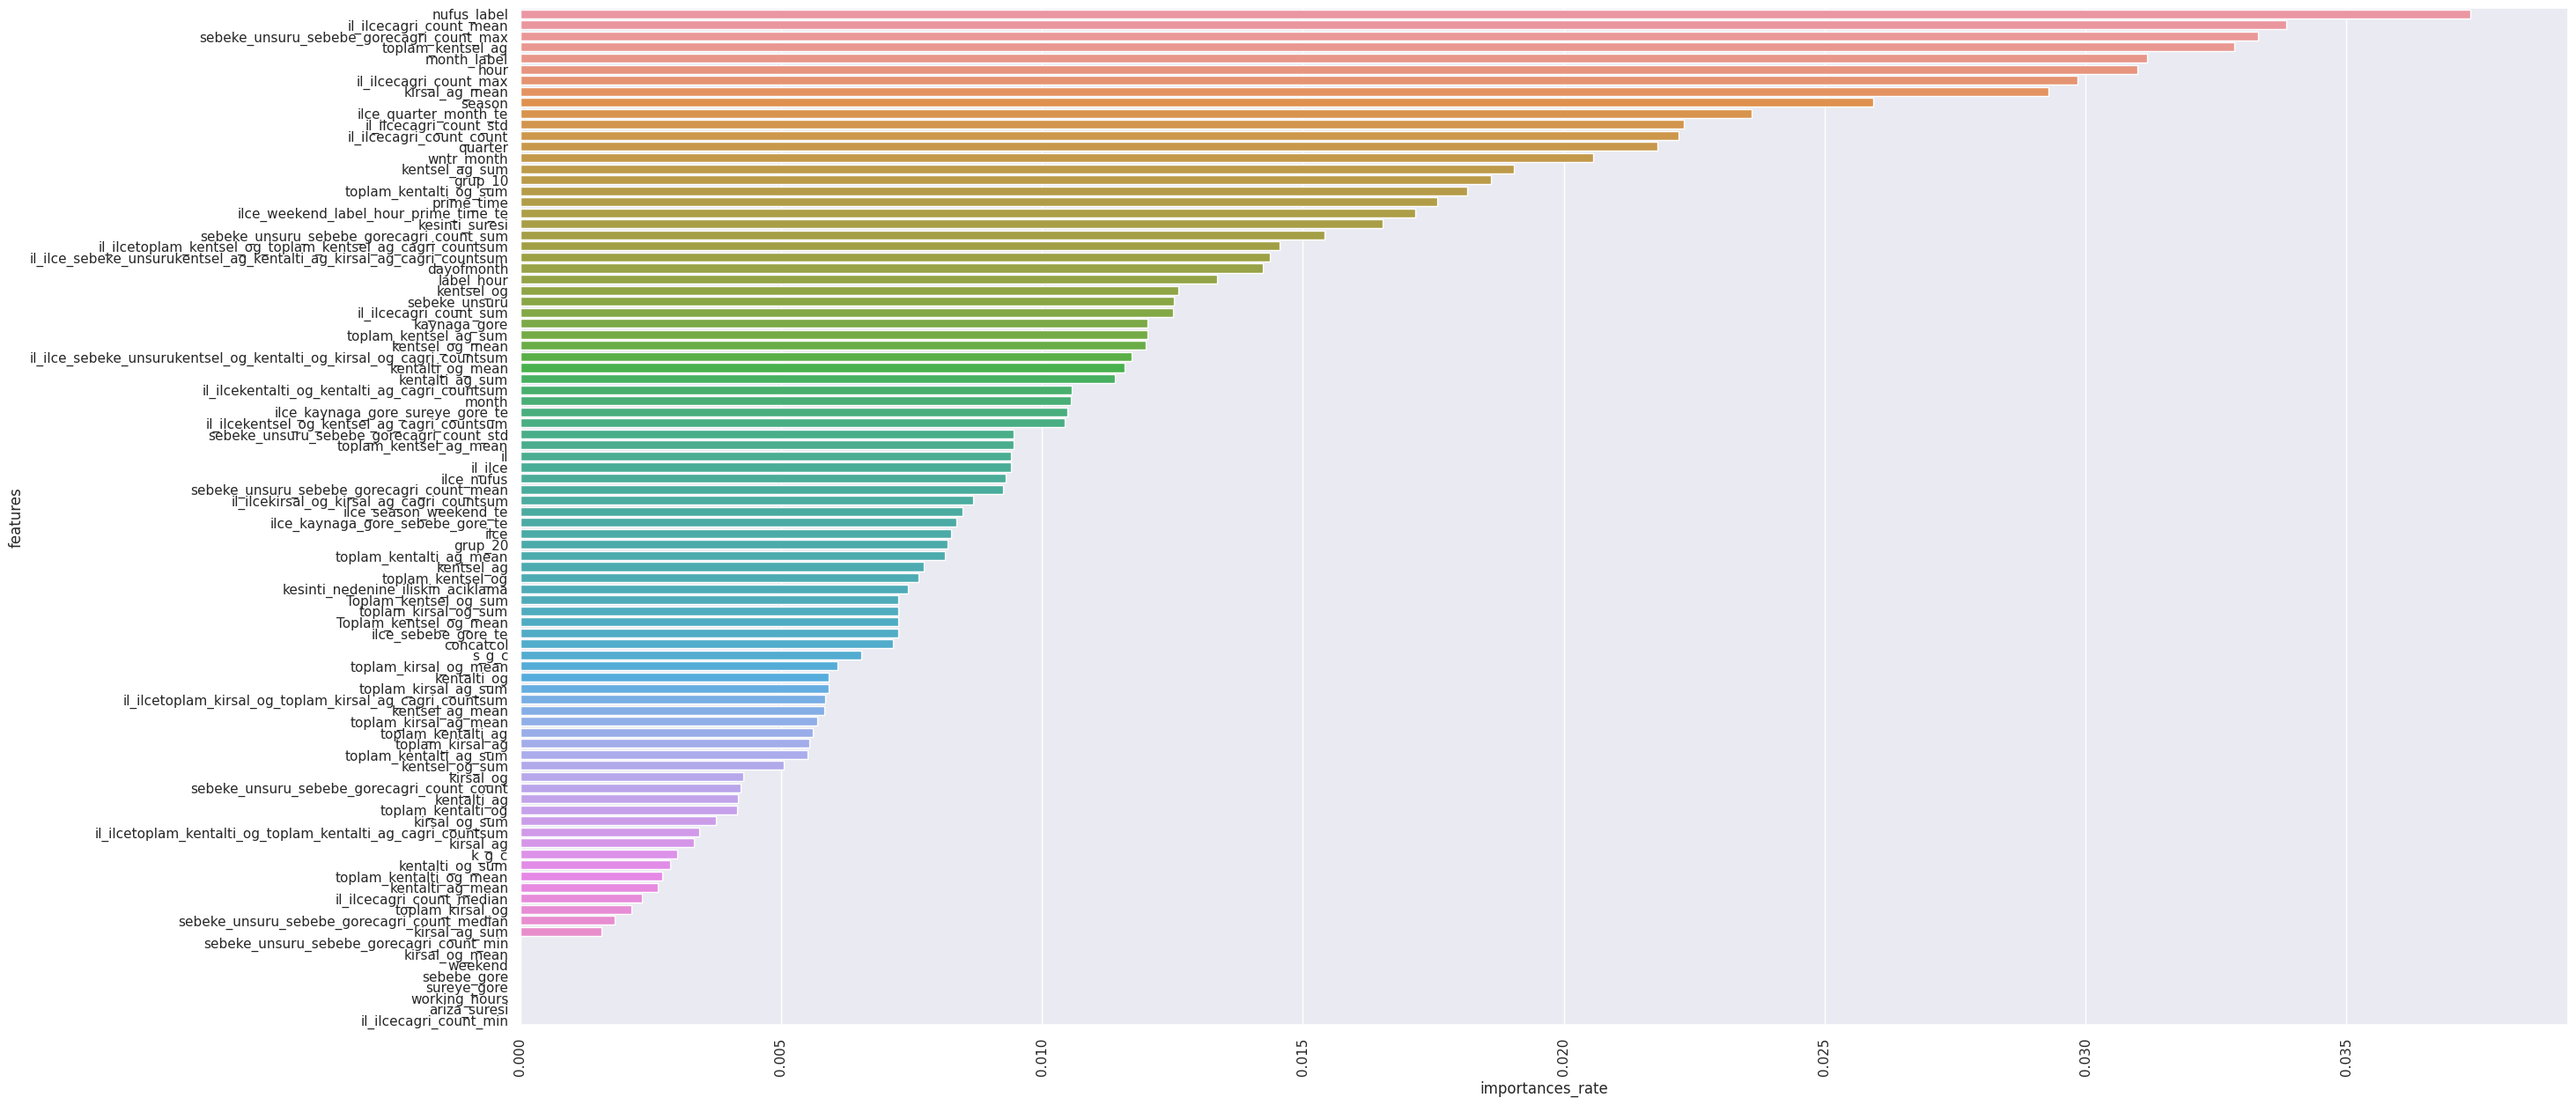

In [24]:
importances=model.feature_importances_
features=test_sub.columns
dum=pd.DataFrame(data={'features':features,'importances_rate':importances}).sort_values('importances_rate',ascending=False)
sns.set(rc={'figure.figsize':(30,15)})
g=sns.barplot(y=dum.features,x=dum.importances_rate,orient='h')
g.set_xticklabels(g.get_xticklabels(), rotation=90);

### Ploting Predicted values

train cagri_count mean: 8.807448880233691
preds cagri_count mean: 9.689233


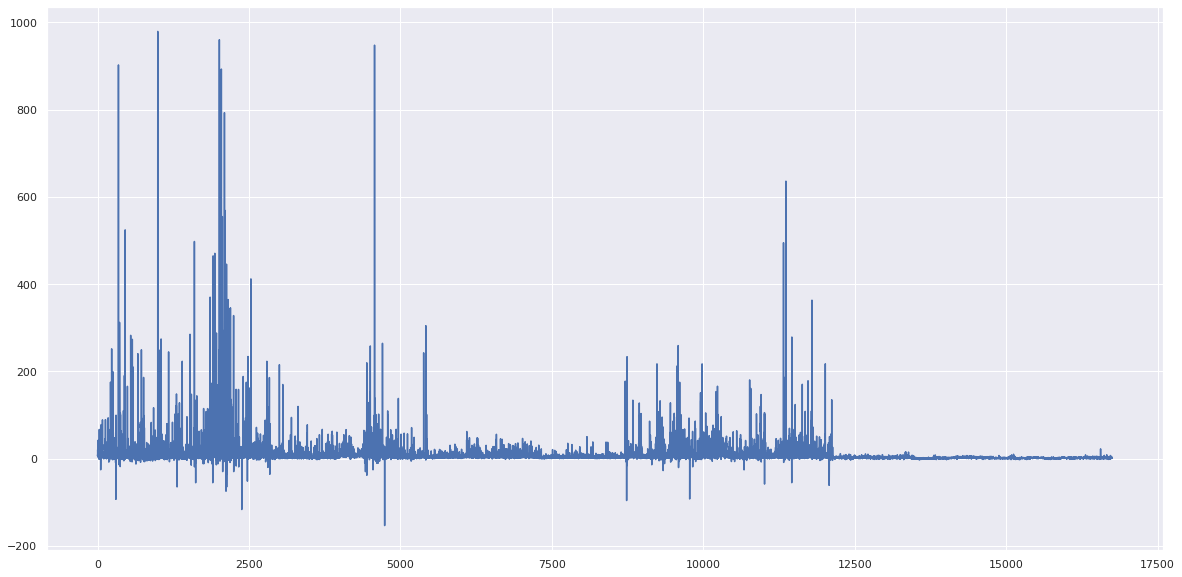

In [73]:
print(f'train cagri_count mean:',train.cagri_count.mean())
print(f'preds cagri_count mean:',np.mean(mean_preds))
plt.figure(figsize=(20,10))
plt.plot(mean_preds);